In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy.fft as fft

In [15]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)
global_counter = 0

cpu


In [16]:
num_frames = 100

num_alphas = 10
alphlowlim = 0.0
alphhighlim = 0.9
num_ds = 50
dlowlim = 0.0
dhighlim = 4.9

In [17]:
alpha_vals = np.linspace(alphlowlim, alphhighlim, num_alphas)
print(alpha_vals)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value

d_vals = np.linspace(dlowlim, dhighlim, num_ds)
d_vals[0] = 1e-10 # set d=0 to a small value
# d_vals = np.ones(num_ds)*2.0
print(d_vals)

s_vals = np.linspace(0.2, 20.0, 101)
s_vals = s_vals[:-1]

r_vals = np.linspace(0.0, 10.0, 501)
r_vals = r_vals[:-1]
r_vals[0] = 1e-10 # set r=0 to a small value

# k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
# k_vals = fft.fftshift(k_vals)
dk = 1/(r_vals[-1]-r_vals[0])
# we need only the positive k values
k_vals = np.linspace(0.0, np.pi*dk, (r_vals.shape[0]))
# k_vals = np.linspace(-np.pi*dk, np.pi*dk, (r_vals.shape[0]))
# k_vals = np.linspace(-np.pi/dk, np.pi/dk, r_vals.shape[0])
# print(k_vals)
print(k_vals.shape)

# convert to tensor
r_vals = torch.from_numpy(r_vals).float().to(device)


# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[1.0e-10 1.0e-01 2.0e-01 3.0e-01 4.0e-01 5.0e-01 6.0e-01 7.0e-01 8.0e-01
 9.0e-01 1.0e+00 1.1e+00 1.2e+00 1.3e+00 1.4e+00 1.5e+00 1.6e+00 1.7e+00
 1.8e+00 1.9e+00 2.0e+00 2.1e+00 2.2e+00 2.3e+00 2.4e+00 2.5e+00 2.6e+00
 2.7e+00 2.8e+00 2.9e+00 3.0e+00 3.1e+00 3.2e+00 3.3e+00 3.4e+00 3.5e+00
 3.6e+00 3.7e+00 3.8e+00 3.9e+00 4.0e+00 4.1e+00 4.2e+00 4.3e+00 4.4e+00
 4.5e+00 4.6e+00 4.7e+00 4.8e+00 4.9e+00]
(500,)
shape of alpha_vals : (10,)
shape of d_vals : (50,)


In [18]:
# initial guess for P_alpha_d
P_alpha_d = np.zeros((s_vals.shape[0], num_alphas, num_ds))
# for i in range(num_frames):
#     P_alpha_d[i, 0, 0] = 1.0


alpha0 = 0.7
d0 = 2.0
for i in range(num_alphas):
    for j in range(num_ds):
        P_alpha_d[:, i, j] = np.exp(-((alpha_vals[i] - alpha0)**2 + (d_vals[j] - d0)**2) / 0.1)

# # normalize P_alpha_d
P_alpha_d = P_alpha_d / np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]
# P_alpha_d = P_alpha_d / np.sum(P_alpha_d, axis=(1, 2))[:, None, None]


# convert to tensor
alpha_vals = torch.from_numpy(alpha_vals).float().to(device)
# convert to tensor
d_vals = torch.from_numpy(d_vals).float().to(device)
# convert to tensor
k_vals = torch.from_numpy(k_vals).float().to(device)

# convert P_alpha_d to torch tensor
P_alpha_d = torch.tensor(P_alpha_d, dtype=torch.float32, device=device, requires_grad=True)
# restrict P_alpha_d to be positive while training
# P_alpha_d = torch.clamp(P_alpha_d, min=0.0)
# print(P_alpha_d)

In [19]:
def contour_plt(P_alpha_d, i=0):
    """
    Visualise P_alpha_d as a countour plot using contourf
    """
    # plot
    # rescale the y axis to be in the range of 0 to 2
    # rescale the x axis to be in the range of 0 to 1000
    # check if P_alpha_d is a torch tensor
    if isinstance(P_alpha_d, torch.Tensor):
        P_alpha_d_copy = P_alpha_d.detach().cpu().numpy()
    else:
        P_alpha_d_copy = P_alpha_d.copy()
    plt.figure(figsize=(4, 4))
    x = np.linspace(dlowlim, dhighlim, num_ds)
    y = np.linspace(alphlowlim, alphhighlim, num_alphas)
    plt.contourf(x, y, P_alpha_d_copy[i], 20, cmap='RdGy')
    plt.xlabel('d')
    plt.ylabel('alpha')
    plt.colorbar()
    plt.show()

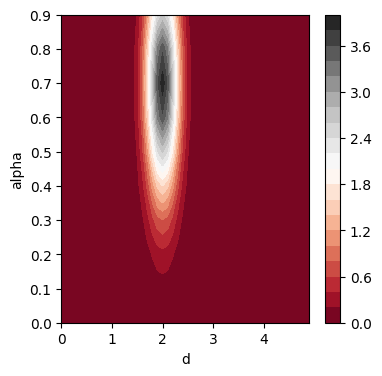

In [20]:
# # visualize P_alpha_d inital in subplots
# for i in range(num_frames):
#     contour_plt(P_alpha_d, i)
contour_plt(P_alpha_d, (s_vals.shape[0]//2))

In [21]:
# load u_pred
u = np.loadtxt("u_ks.txt")
print(f"shape of u : {u.shape}")
# print(u_pred)
# convert to torch tensor
u = torch.tensor(u, dtype=torch.float32, device=device)
print(f"shape of u : {u.shape}")

shape of u : (100, 500)
shape of u : torch.Size([100, 500])


In [22]:
# load Z
Z = np.load("Z_ks.npy")
print(f"shape of Z : {Z.shape}")
# convert Z to torch tensor
Z = torch.from_numpy(Z).float().to(device)
# print shape of Z
print(f"shape of Z : {Z.shape}")
# print(Z)
######################## check ########################
# normalize Z to have integral of Z over r equal to 1
# Z = Z / np.sum(Z * (r_vals[1]-r_vals[0]))
# print(Z)

shape of Z : (100, 500, 10, 50)
shape of Z : torch.Size([100, 500, 10, 50])


In [23]:
def give_u_pred(P_alpha_d, Z, alpha_vals, d_vals):
    """
    Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
    """
    # initialize u_pred
    u_pred = torch.zeros((s_vals.shape[0], len(r_vals)))
    # move u_pred to device
    u_pred = u_pred.to(device)

    # unvectorized version
    # for i in range(u_pred.shape[0]):
    #     for j in range(u_pred.shape[1]):
    #         integrand = torch.trapz(P_alpha_d[i] * Z[i, j, :, :], d_vals)
    #         u_pred[i, j] = torch.trapz(integrand, alpha_vals)
    # unvectorized version

    # vectorized version
    u_pred = torch.trapz(torch.trapz(P_alpha_d[:, None, :, :] * Z, d_vals, dim=3), alpha_vals, dim=2)
    # vectorized version

    
    ######################## check ########################
    # normalize u_pred
    # u_pred = u_pred / (u_pred.sum(dim=1, keepdim=True) + 1e-9)
    # u_pred = u_pred / (torch.trapz(u_pred, k_vals, dim=1, keepdim=True))
    # norm = torch.trapz(u_pred, k_vals, dim=1)
    # u_pred = u_pred / norm[:, None]
    # u_pred = u_pred / np.trapz(u_pred, k_vals, axis=1).reshape(-1, 1)
    
    norm = (torch.trapz(u_pred, k_vals, dim=1))

    u_pred = u_pred / norm[:, None]


    return u_pred    

In [24]:
# manual loss function
def loss_function(P_alpha_d, u, Z, alpha_vals, d_vals, global_counter):
    # clamp P_alpha_d to be positive
    # P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)

    # normalize P_alpha_d
    norm = (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1))
    P_alpha_d = P_alpha_d / norm[:, None, None]


    # P_alpha_d = P_alpha_d / (torch.trapz(torch.trapz(P_alpha_d, d_vals, dim=2), alpha_vals, dim=1, keepdim=True) + 1e-6)
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True))
    # P_alpha_d = P_alpha_d / (P_alpha_d.sum(dim=(1,2), keepdim=True) + 1e-6)
    # calculate u_pred using double integral
    u_pred = give_u_pred(P_alpha_d, Z, alpha_vals, d_vals)
    # calculate loss
    loss = torch.sum((u_pred - u)**2)
    # loss /= u.shape[0] * u.shape[1]
    # loss = torch.sum(abs(u_pred - u))
    # plot u_pred and u
    if(global_counter%5 == 0):
        plt.plot(u_pred.detach().cpu().numpy()[20], label='u_pred')
        plt.plot(u.detach().cpu().numpy()[20], label='u')
        plt.legend()
        plt.show()

    return loss

In [25]:
# write a function to train the model
def train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=100, lr=1e-1):
    # define the optimizer
    optimizer = torch.optim.Adam([P_alpha_d], lr=lr)
    # define the loss function
    loss_func = loss_function
    # define the loss history
    loss_history = []
    global_counter = 0
    # train the model
    for epoch in range(num_epochs):
        # calculate loss
        loss = loss_func(P_alpha_d, u, Z, alpha_vals, d_vals, global_counter)
        # zero the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update parameters
        optimizer.step()
        # append loss to loss history
        loss_history.append(loss.item())
        P_alpha_d.data = P_alpha_d.data.clamp(min=0.0)
        global_counter += 1
        # plot P_alpha_d
        if (epoch+1) % 5 == 0:
            contour_plt(P_alpha_d, (s_vals.shape[0]//2))
        # print loss
        if (epoch+1) % 1 == 0:
            print(f"epoch {epoch+1} / {num_epochs} : loss = {loss.item()}")
    # plot loss history
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return P_alpha_d

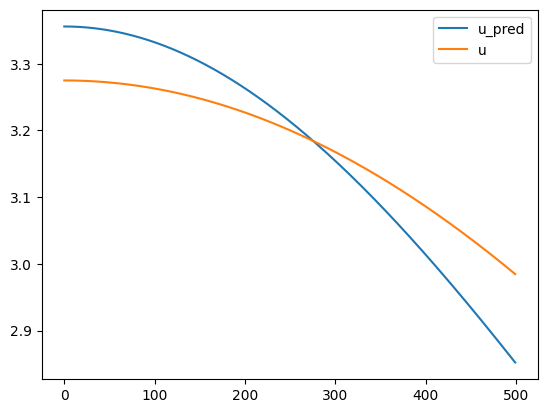

/home2/mkrishnapraneet/miniconda3/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch 1 / 500 : loss = 173.88792419433594
epoch 2 / 500 : loss = 165.89962768554688
epoch 3 / 500 : loss = 158.53158569335938
epoch 4 / 500 : loss = 151.6407012939453


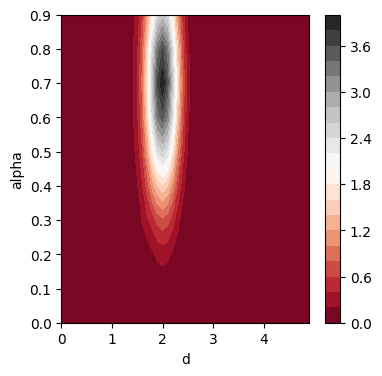

epoch 5 / 500 : loss = 145.15982055664062


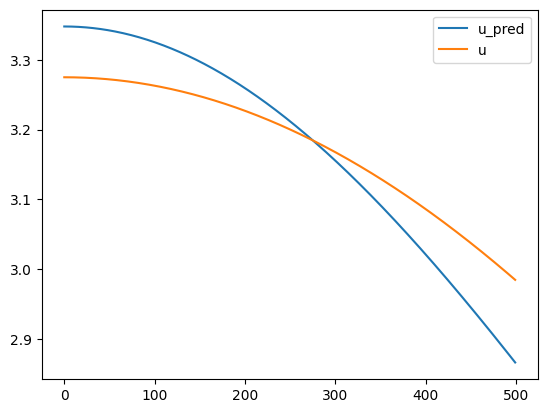

epoch 6 / 500 : loss = 139.0081329345703
epoch 7 / 500 : loss = 133.155517578125
epoch 8 / 500 : loss = 127.59211730957031
epoch 9 / 500 : loss = 122.35697937011719


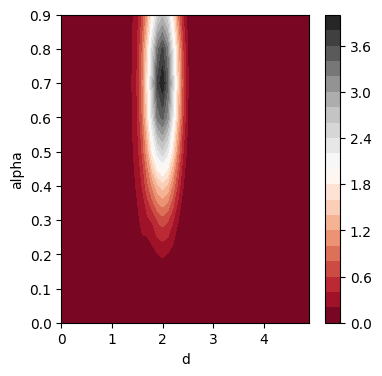

epoch 10 / 500 : loss = 117.36988830566406


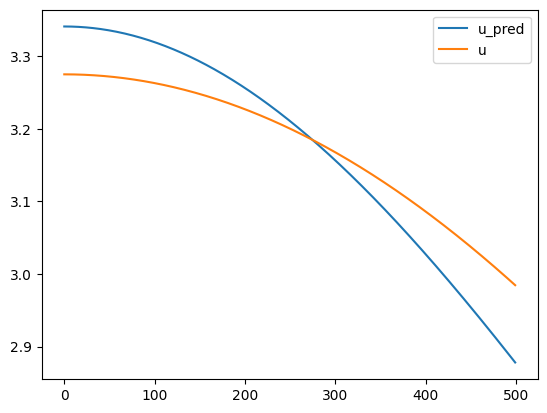

epoch 11 / 500 : loss = 112.62532043457031
epoch 12 / 500 : loss = 108.15074157714844
epoch 13 / 500 : loss = 103.90095520019531
epoch 14 / 500 : loss = 99.83966064453125


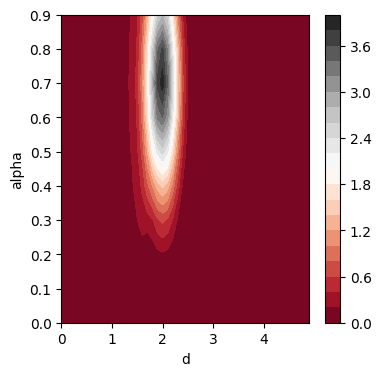

epoch 15 / 500 : loss = 95.99588775634766


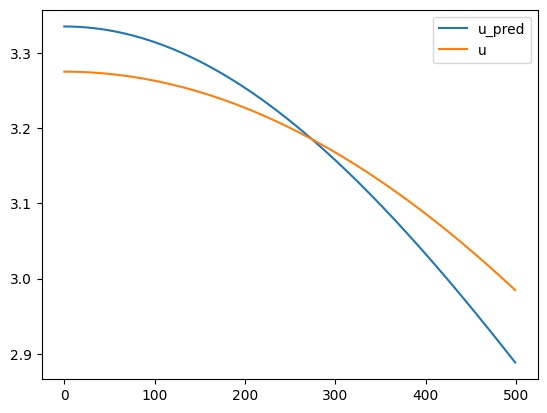

epoch 16 / 500 : loss = 92.32760620117188
epoch 17 / 500 : loss = 88.81765747070312
epoch 18 / 500 : loss = 85.4756088256836
epoch 19 / 500 : loss = 82.27781677246094


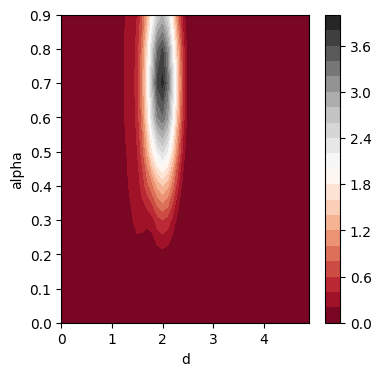

epoch 20 / 500 : loss = 79.21369934082031


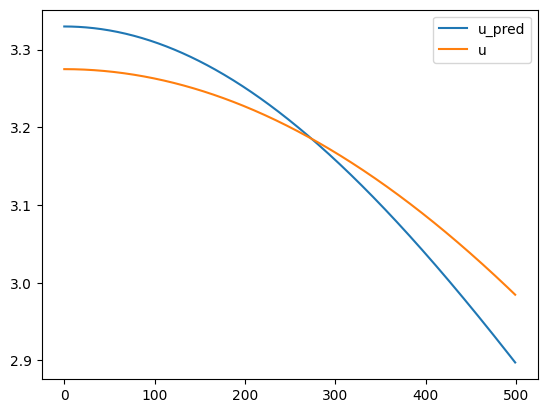

epoch 21 / 500 : loss = 76.27619171142578
epoch 22 / 500 : loss = 73.45917510986328
epoch 23 / 500 : loss = 70.77012634277344
epoch 24 / 500 : loss = 68.22074890136719


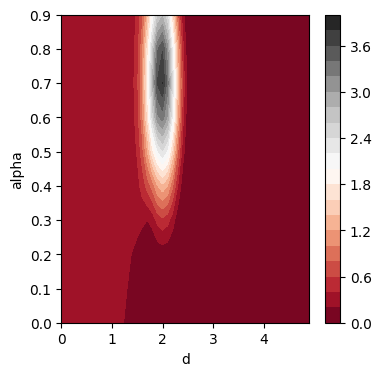

epoch 25 / 500 : loss = 65.77281188964844


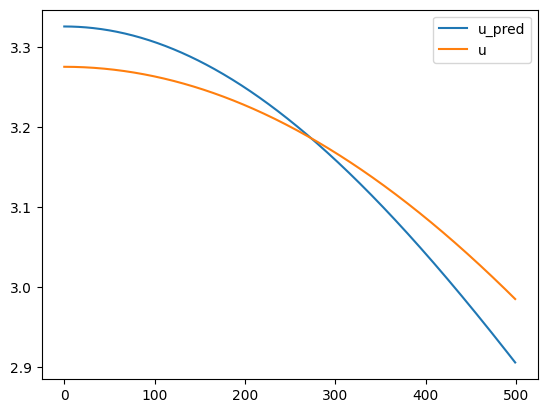

epoch 26 / 500 : loss = 63.42076873779297
epoch 27 / 500 : loss = 61.159576416015625
epoch 28 / 500 : loss = 58.98462677001953
epoch 29 / 500 : loss = 56.89237976074219


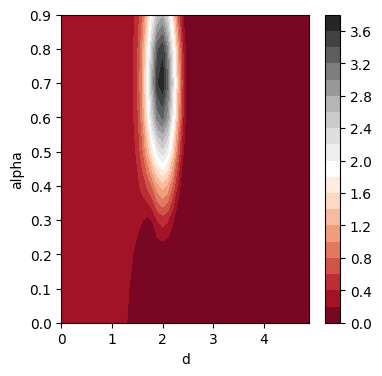

epoch 30 / 500 : loss = 54.88336181640625


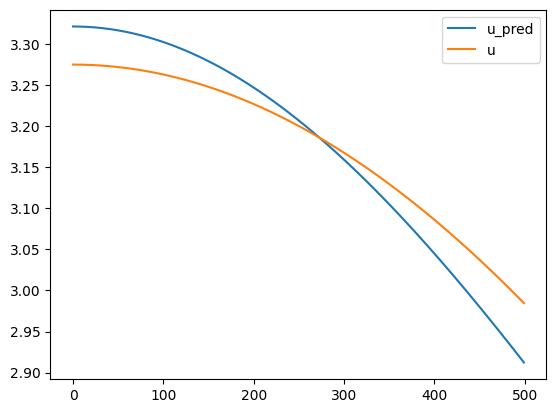

epoch 31 / 500 : loss = 52.969879150390625
epoch 32 / 500 : loss = 51.149925231933594
epoch 33 / 500 : loss = 49.399749755859375
epoch 34 / 500 : loss = 47.72309875488281


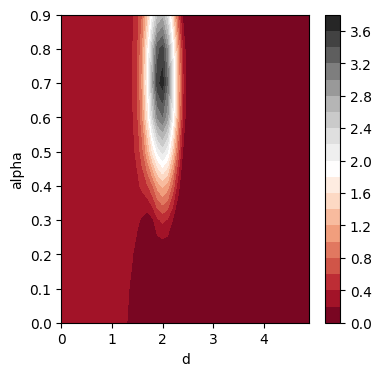

epoch 35 / 500 : loss = 46.135555267333984


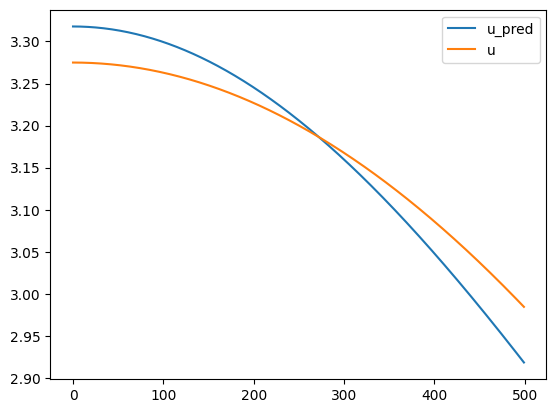

epoch 36 / 500 : loss = 44.61290740966797
epoch 37 / 500 : loss = 43.14323425292969
epoch 38 / 500 : loss = 41.72403335571289
epoch 39 / 500 : loss = 40.352943420410156


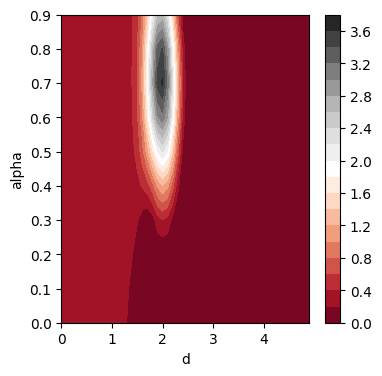

epoch 40 / 500 : loss = 39.027809143066406


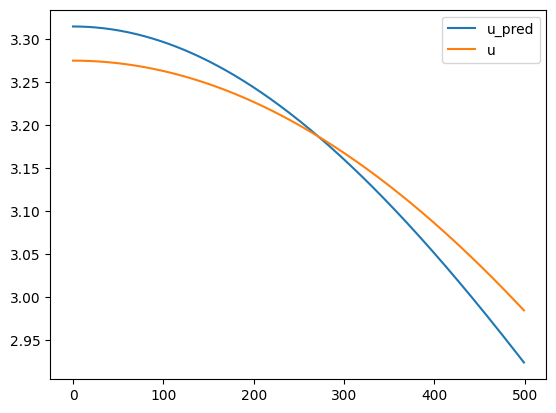

epoch 41 / 500 : loss = 37.74652862548828
epoch 42 / 500 : loss = 36.507225036621094
epoch 43 / 500 : loss = 35.30805206298828
epoch 44 / 500 : loss = 34.147315979003906


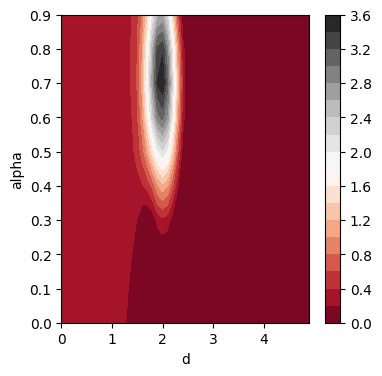

epoch 45 / 500 : loss = 33.023353576660156


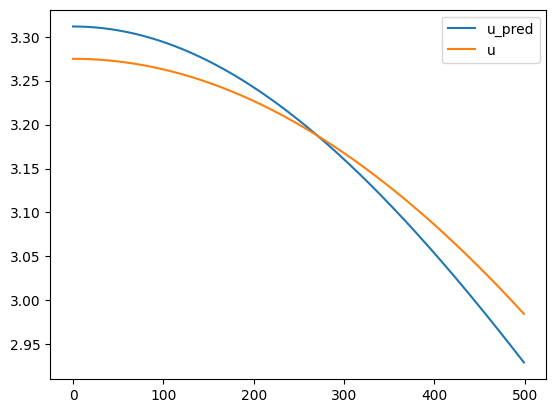

epoch 46 / 500 : loss = 31.934741973876953
epoch 47 / 500 : loss = 30.879993438720703
epoch 48 / 500 : loss = 29.85772705078125
epoch 49 / 500 : loss = 28.866657257080078


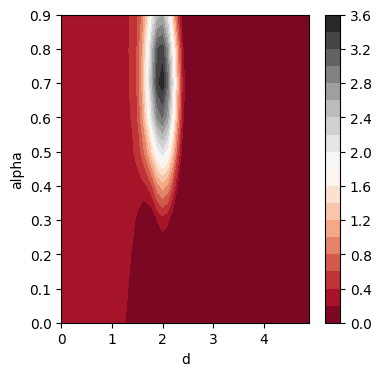

epoch 50 / 500 : loss = 27.90557289123535


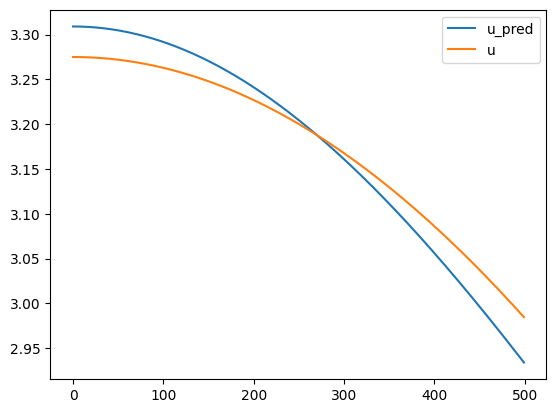

epoch 51 / 500 : loss = 26.974395751953125
epoch 52 / 500 : loss = 26.072032928466797
epoch 53 / 500 : loss = 25.197603225708008
epoch 54 / 500 : loss = 24.350360870361328


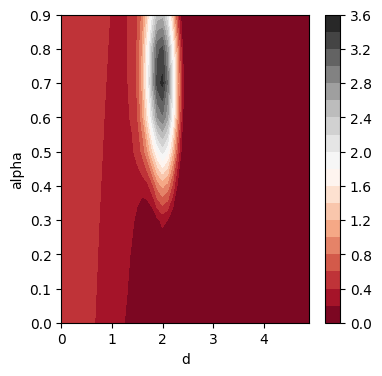

epoch 55 / 500 : loss = 23.53020477294922


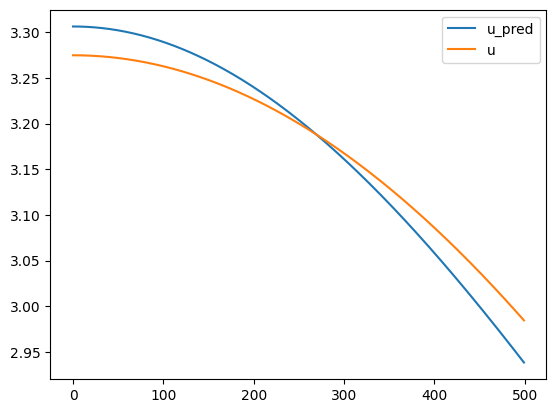

epoch 56 / 500 : loss = 22.73628807067871
epoch 57 / 500 : loss = 21.967952728271484
epoch 58 / 500 : loss = 21.225727081298828
epoch 59 / 500 : loss = 20.50872039794922


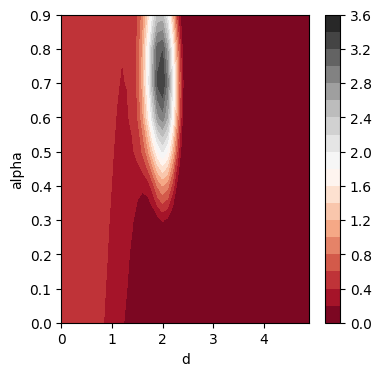

epoch 60 / 500 : loss = 19.815631866455078


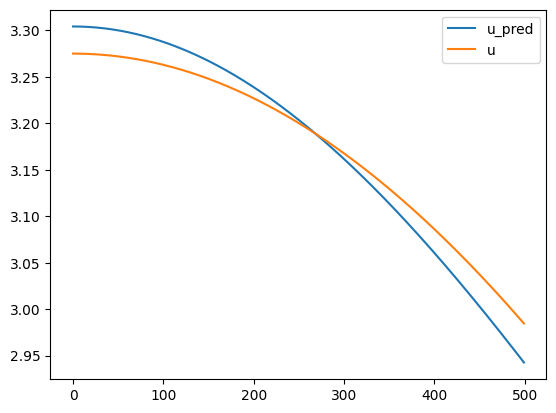

epoch 61 / 500 : loss = 19.144912719726562
epoch 62 / 500 : loss = 18.494293212890625
epoch 63 / 500 : loss = 17.862424850463867
epoch 64 / 500 : loss = 17.248641967773438


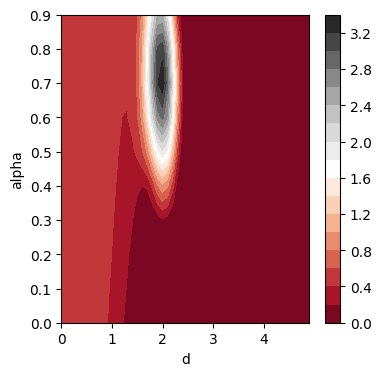

epoch 65 / 500 : loss = 16.65241241455078


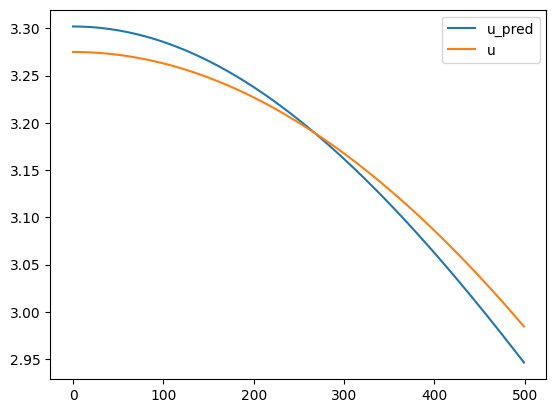

epoch 66 / 500 : loss = 16.073265075683594
epoch 67 / 500 : loss = 15.510656356811523
epoch 68 / 500 : loss = 14.964486122131348
epoch 69 / 500 : loss = 14.43452262878418


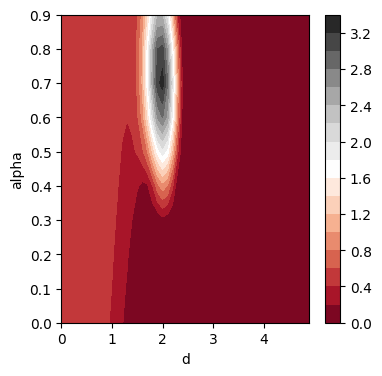

epoch 70 / 500 : loss = 13.920913696289062


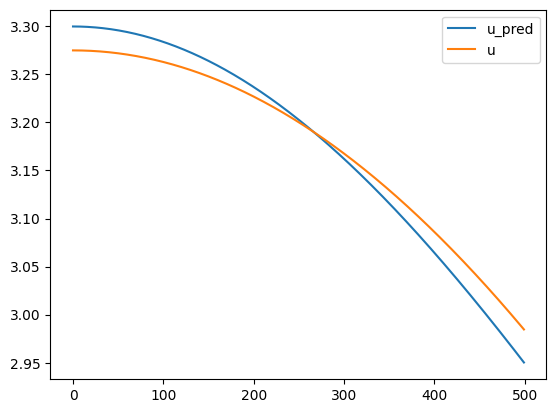

epoch 71 / 500 : loss = 13.42342758178711
epoch 72 / 500 : loss = 12.94180965423584
epoch 73 / 500 : loss = 12.475563049316406
epoch 74 / 500 : loss = 12.024308204650879


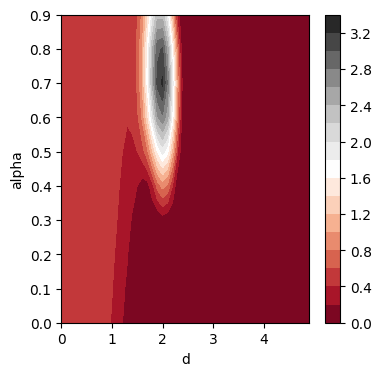

epoch 75 / 500 : loss = 11.587987899780273


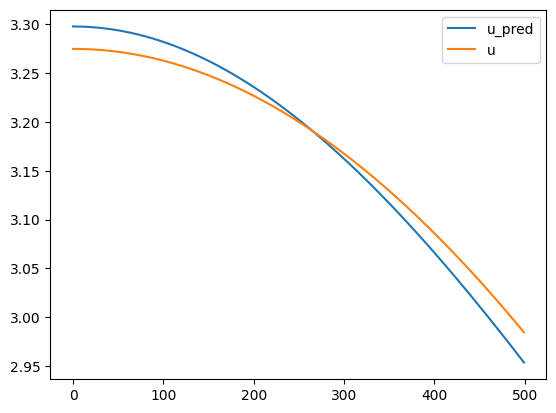

epoch 76 / 500 : loss = 11.166553497314453
epoch 77 / 500 : loss = 10.759519577026367
epoch 78 / 500 : loss = 10.366551399230957
epoch 79 / 500 : loss = 9.987470626831055


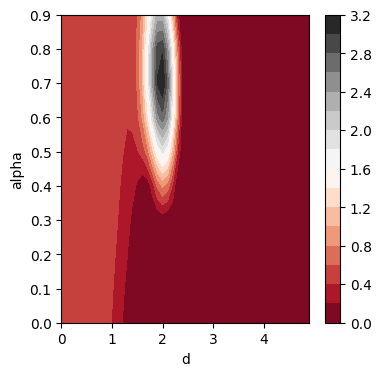

epoch 80 / 500 : loss = 9.622108459472656


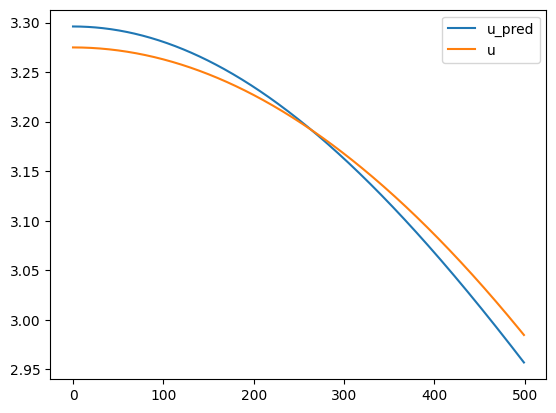

epoch 81 / 500 : loss = 9.26981258392334
epoch 82 / 500 : loss = 8.929826736450195
epoch 83 / 500 : loss = 8.601529121398926
epoch 84 / 500 : loss = 8.284385681152344


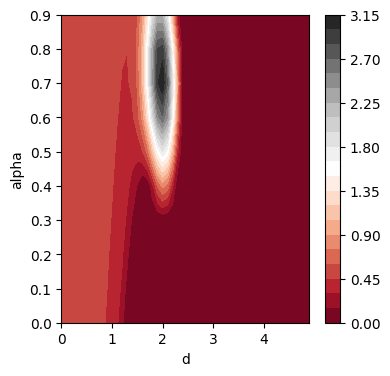

epoch 85 / 500 : loss = 7.977785587310791


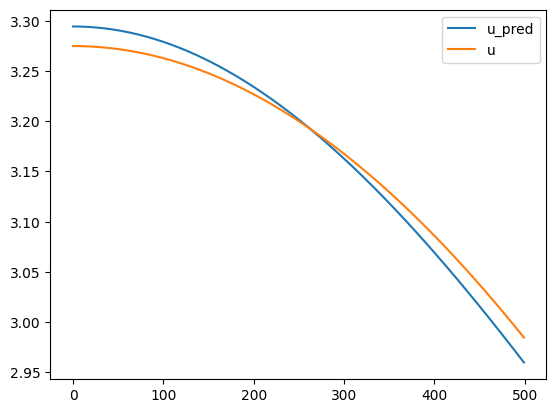

epoch 86 / 500 : loss = 7.681107521057129
epoch 87 / 500 : loss = 7.393789291381836
epoch 88 / 500 : loss = 7.115548133850098
epoch 89 / 500 : loss = 6.846081733703613


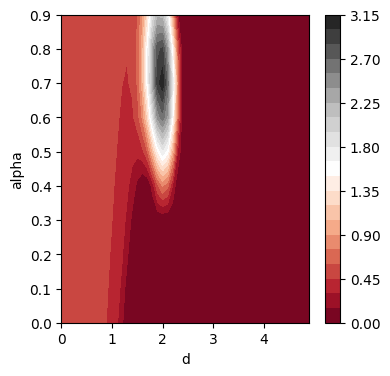

epoch 90 / 500 : loss = 6.585238456726074


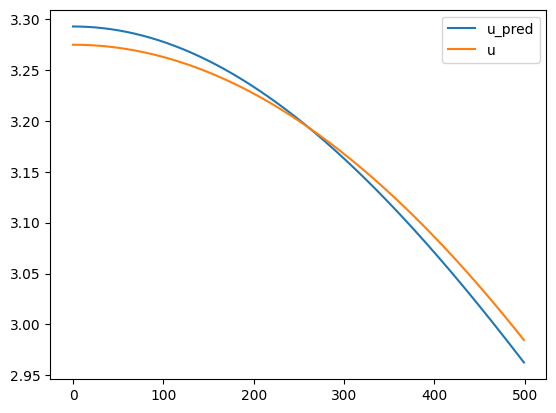

epoch 91 / 500 : loss = 6.333868026733398
epoch 92 / 500 : loss = 6.092723369598389
epoch 93 / 500 : loss = 5.8595075607299805
epoch 94 / 500 : loss = 5.633663177490234


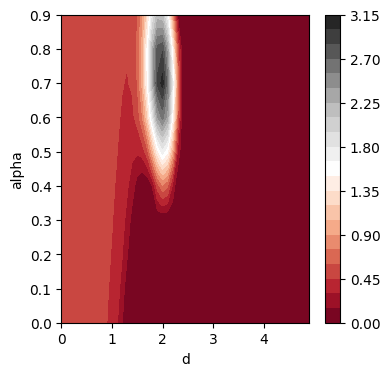

epoch 95 / 500 : loss = 5.415054798126221


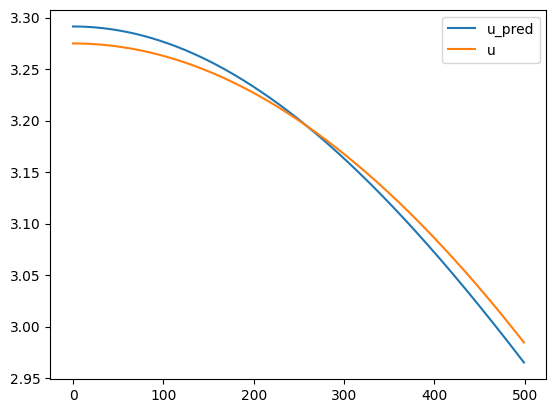

epoch 96 / 500 : loss = 5.203399181365967
epoch 97 / 500 : loss = 4.998622417449951
epoch 98 / 500 : loss = 4.800487518310547
epoch 99 / 500 : loss = 4.608834743499756


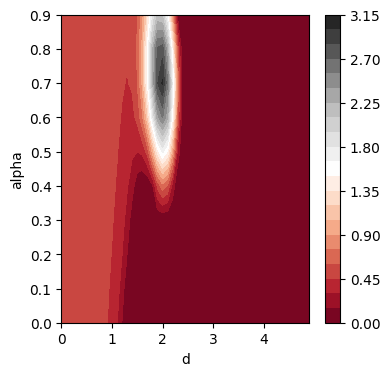

epoch 100 / 500 : loss = 4.423503875732422


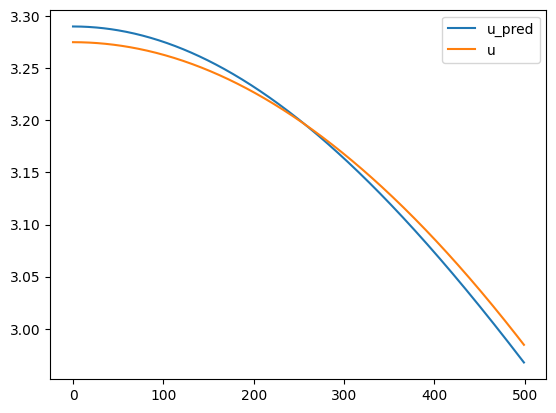

epoch 101 / 500 : loss = 4.244349479675293
epoch 102 / 500 : loss = 4.071172714233398
epoch 103 / 500 : loss = 3.9038245677948
epoch 104 / 500 : loss = 3.742116689682007


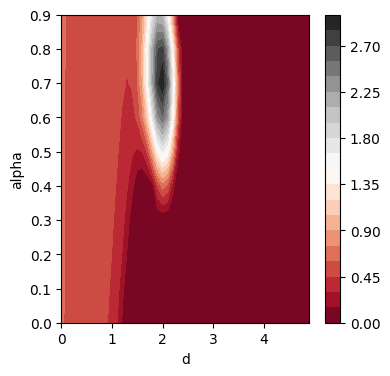

epoch 105 / 500 : loss = 3.5859079360961914


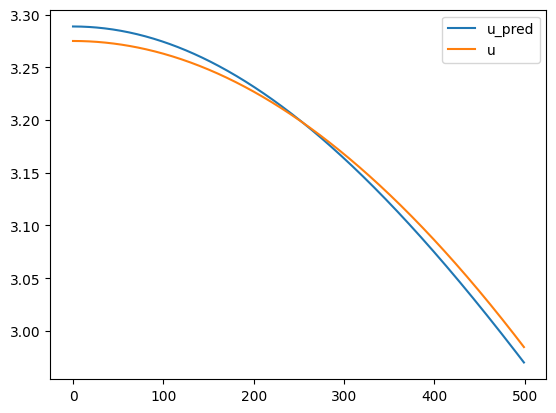

epoch 106 / 500 : loss = 3.4350597858428955
epoch 107 / 500 : loss = 3.289454936981201
epoch 108 / 500 : loss = 3.1489367485046387
epoch 109 / 500 : loss = 3.0134072303771973


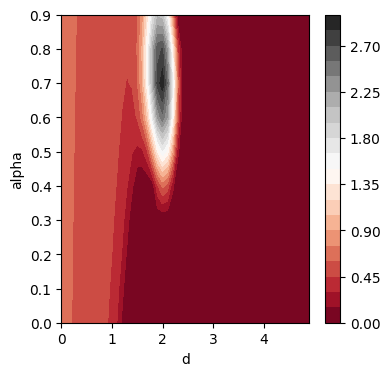

epoch 110 / 500 : loss = 2.8827261924743652


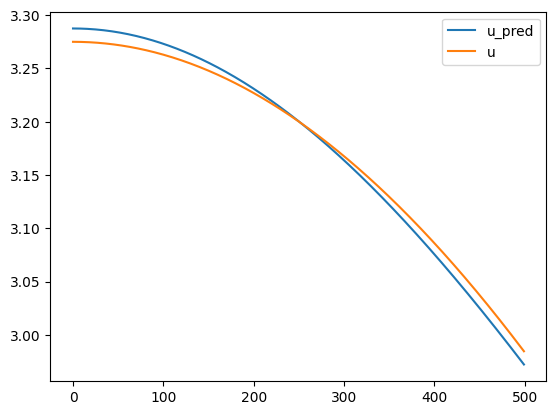

epoch 111 / 500 : loss = 2.7567620277404785
epoch 112 / 500 : loss = 2.6354355812072754
epoch 113 / 500 : loss = 2.5186073780059814
epoch 114 / 500 : loss = 2.406219482421875


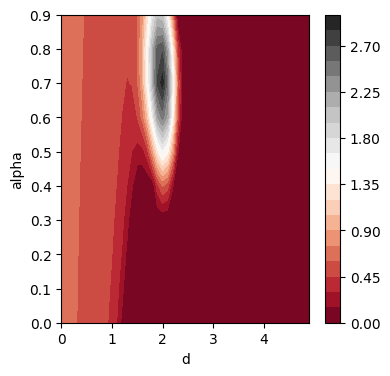

epoch 115 / 500 : loss = 2.298129081726074


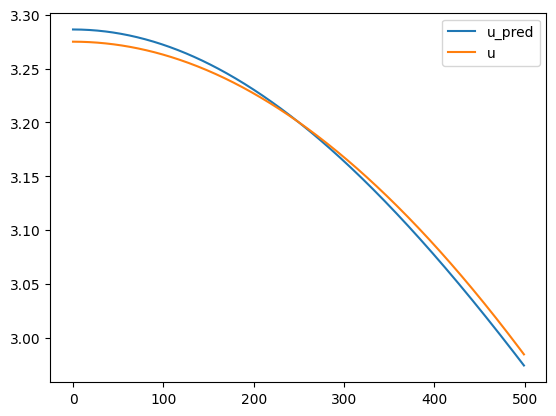

epoch 116 / 500 : loss = 2.1942451000213623
epoch 117 / 500 : loss = 2.0944738388061523
epoch 118 / 500 : loss = 1.998670220375061
epoch 119 / 500 : loss = 1.9067249298095703


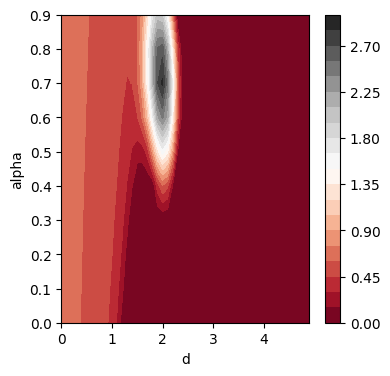

epoch 120 / 500 : loss = 1.8185285329818726


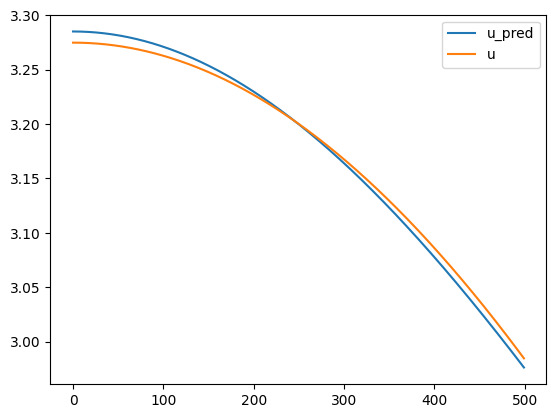

epoch 121 / 500 : loss = 1.7339560985565186
epoch 122 / 500 : loss = 1.6529107093811035
epoch 123 / 500 : loss = 1.575282335281372
epoch 124 / 500 : loss = 1.5009418725967407


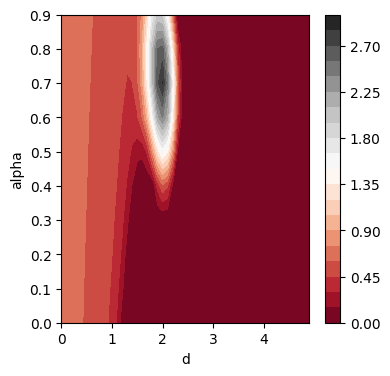

epoch 125 / 500 : loss = 1.4298322200775146


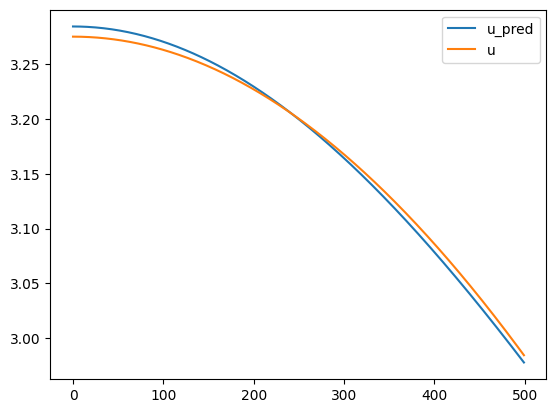

epoch 126 / 500 : loss = 1.3618546724319458
epoch 127 / 500 : loss = 1.296905279159546
epoch 128 / 500 : loss = 1.234887719154358
epoch 129 / 500 : loss = 1.1756808757781982


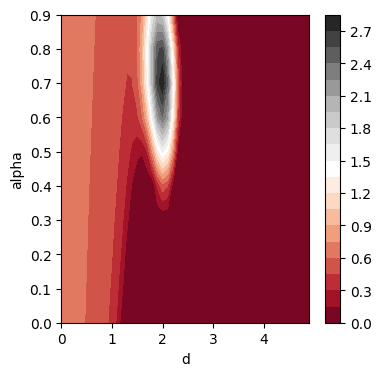

epoch 130 / 500 : loss = 1.1192073822021484


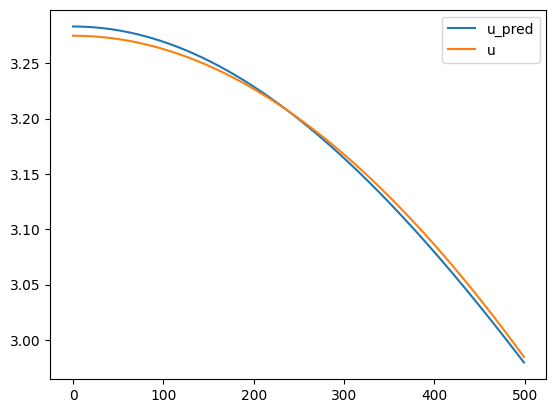

epoch 131 / 500 : loss = 1.0653660297393799
epoch 132 / 500 : loss = 1.0140584707260132
epoch 133 / 500 : loss = 0.9651814103126526
epoch 134 / 500 : loss = 0.9186606407165527


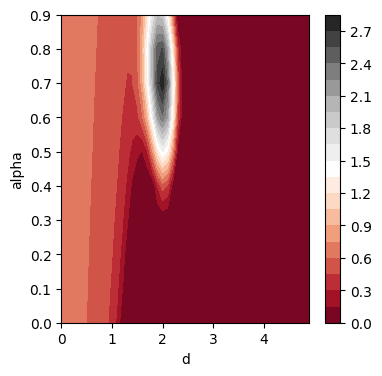

epoch 135 / 500 : loss = 0.874428391456604


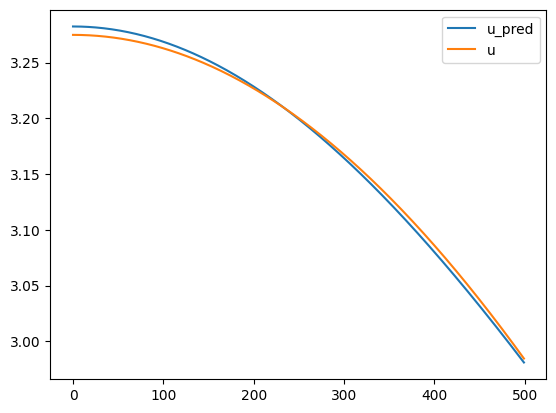

epoch 136 / 500 : loss = 0.8323733806610107
epoch 137 / 500 : loss = 0.7924002408981323
epoch 138 / 500 : loss = 0.7544289827346802
epoch 139 / 500 : loss = 0.7183799743652344


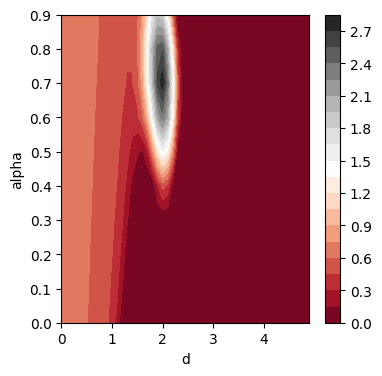

epoch 140 / 500 : loss = 0.6841749548912048


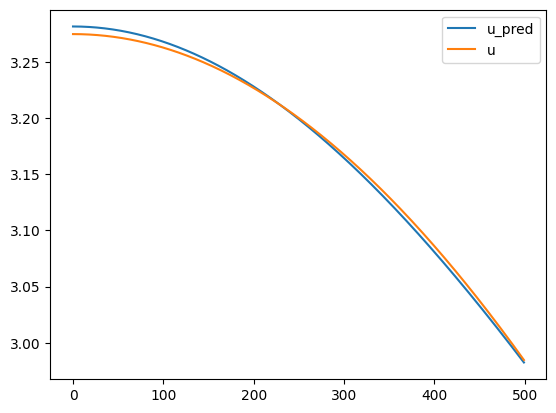

epoch 141 / 500 : loss = 0.6517361402511597
epoch 142 / 500 : loss = 0.6209916472434998
epoch 143 / 500 : loss = 0.5918548107147217
epoch 144 / 500 : loss = 0.5642739534378052


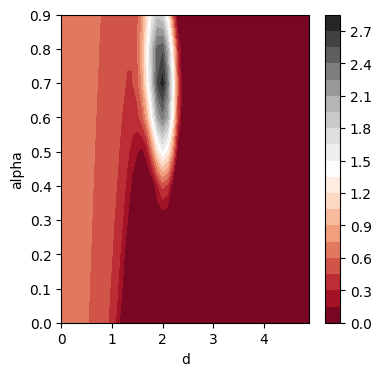

epoch 145 / 500 : loss = 0.5381743907928467


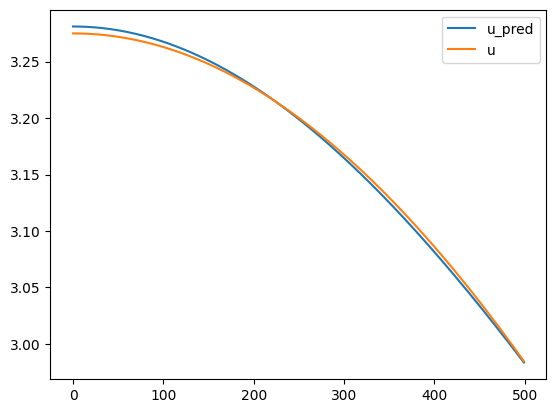

epoch 146 / 500 : loss = 0.5134816765785217
epoch 147 / 500 : loss = 0.49014705419540405
epoch 148 / 500 : loss = 0.46810382604599
epoch 149 / 500 : loss = 0.44728997349739075


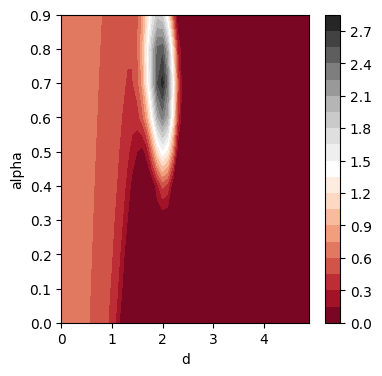

epoch 150 / 500 : loss = 0.42765703797340393


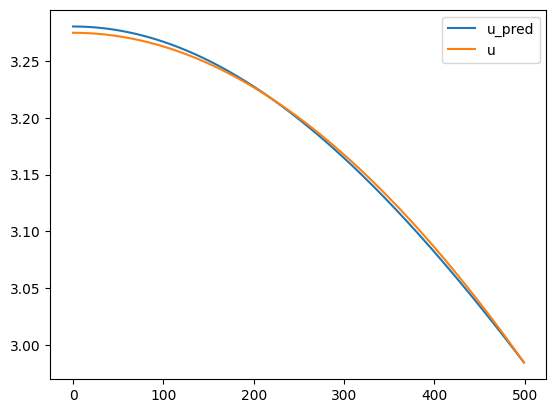

epoch 151 / 500 : loss = 0.40913987159729004
epoch 152 / 500 : loss = 0.39168640971183777
epoch 153 / 500 : loss = 0.3752491772174835
epoch 154 / 500 : loss = 0.35977622866630554


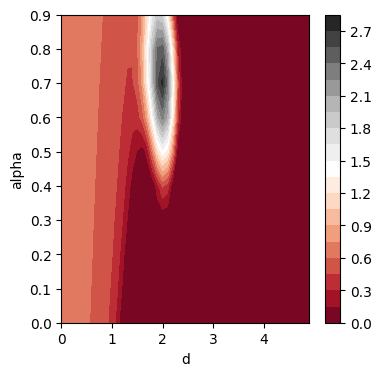

epoch 155 / 500 : loss = 0.34521734714508057


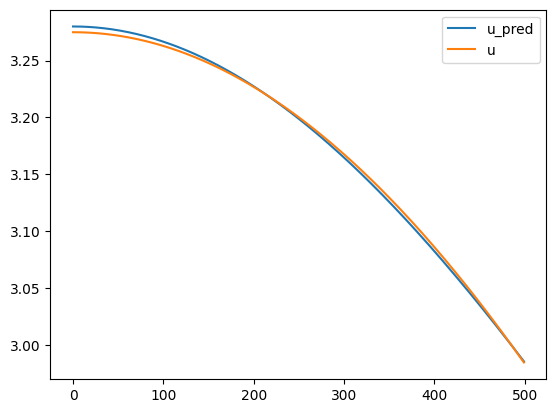

epoch 156 / 500 : loss = 0.3315385580062866
epoch 157 / 500 : loss = 0.3186853229999542
epoch 158 / 500 : loss = 0.3066160976886749
epoch 159 / 500 : loss = 0.2952879071235657


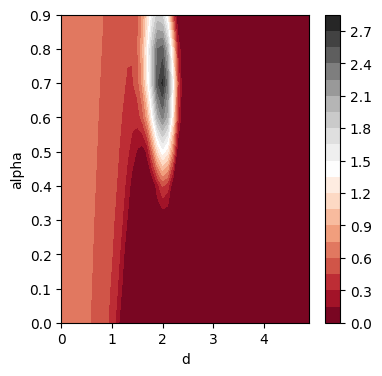

epoch 160 / 500 : loss = 0.28466880321502686


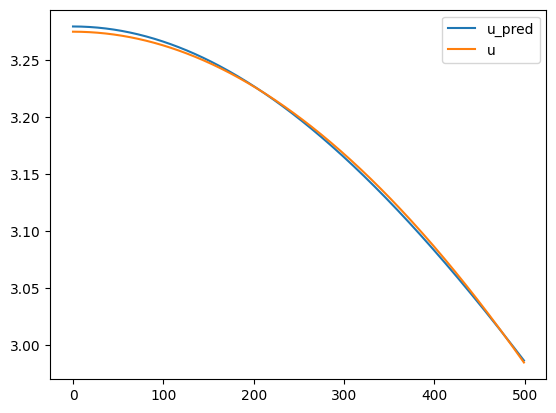

epoch 161 / 500 : loss = 0.27471309900283813
epoch 162 / 500 : loss = 0.26538991928100586
epoch 163 / 500 : loss = 0.2566637098789215
epoch 164 / 500 : loss = 0.24850308895111084


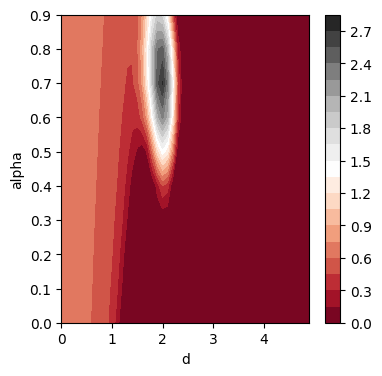

epoch 165 / 500 : loss = 0.24087734520435333


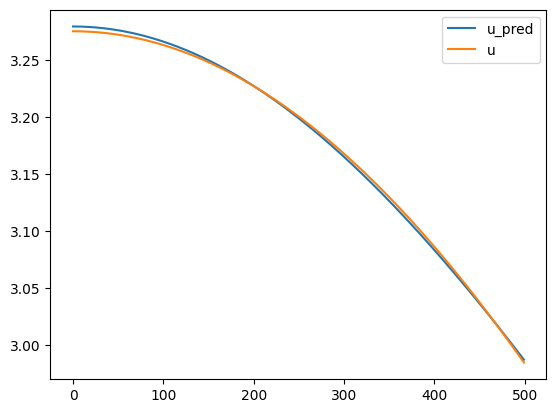

epoch 166 / 500 : loss = 0.2337532937526703
epoch 167 / 500 : loss = 0.22710610926151276
epoch 168 / 500 : loss = 0.22090637683868408
epoch 169 / 500 : loss = 0.21512791514396667


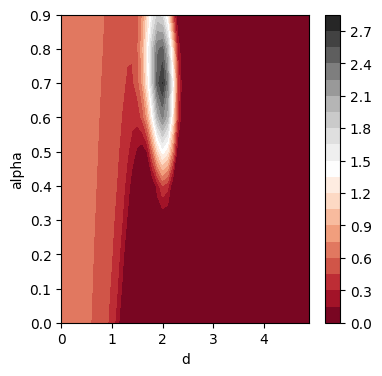

epoch 170 / 500 : loss = 0.20974676311016083


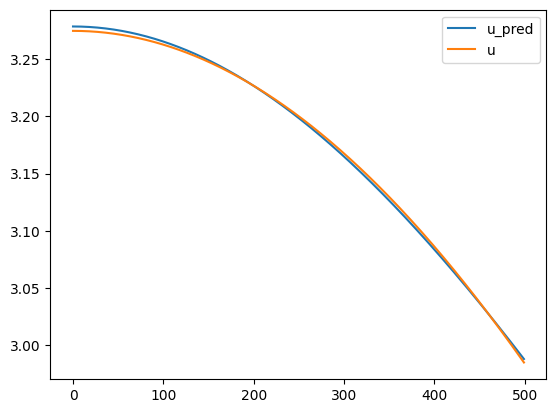

epoch 171 / 500 : loss = 0.20473691821098328
epoch 172 / 500 : loss = 0.20007698237895966
epoch 173 / 500 : loss = 0.19574898481369019
epoch 174 / 500 : loss = 0.191729336977005


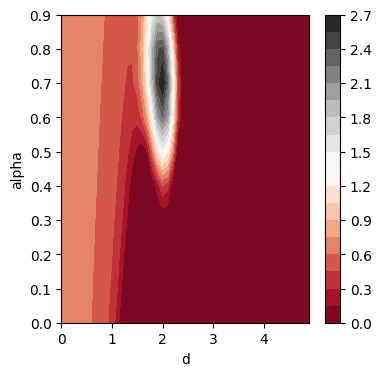

epoch 175 / 500 : loss = 0.1879991888999939


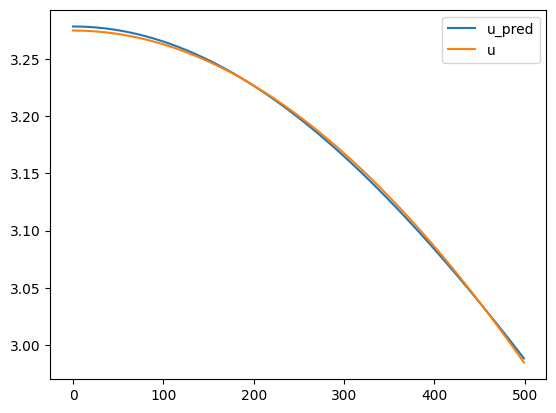

epoch 176 / 500 : loss = 0.18454012274742126
epoch 177 / 500 : loss = 0.18133418262004852
epoch 178 / 500 : loss = 0.17836537957191467
epoch 179 / 500 : loss = 0.17561985552310944


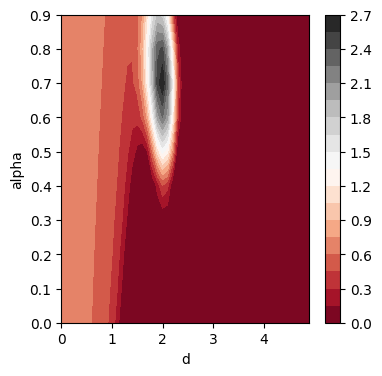

epoch 180 / 500 : loss = 0.17308153212070465


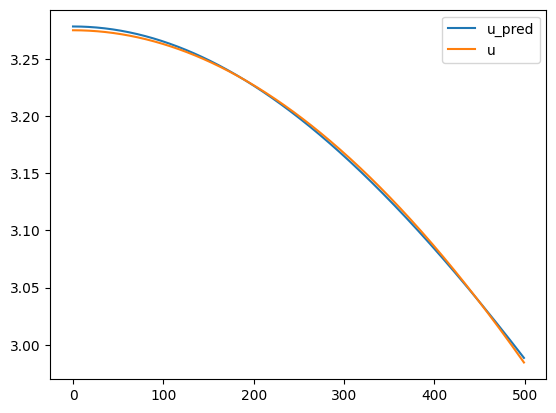

epoch 181 / 500 : loss = 0.17073622345924377
epoch 182 / 500 : loss = 0.1685720682144165
epoch 183 / 500 : loss = 0.16657596826553345
epoch 184 / 500 : loss = 0.16473671793937683


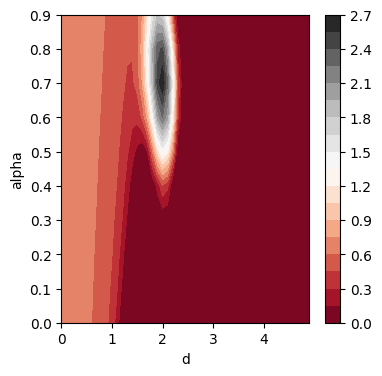

epoch 185 / 500 : loss = 0.16304293274879456


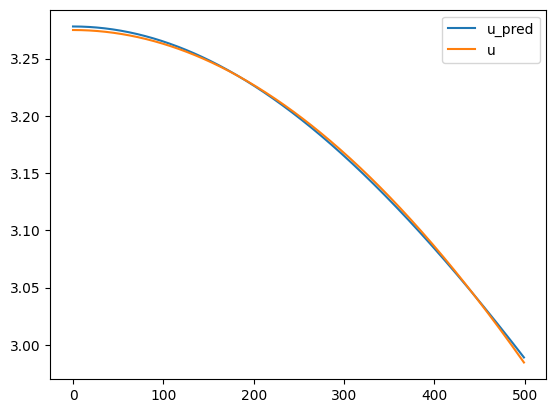

epoch 186 / 500 : loss = 0.16148558259010315
epoch 187 / 500 : loss = 0.16005361080169678
epoch 188 / 500 : loss = 0.15873849391937256
epoch 189 / 500 : loss = 0.1575324535369873


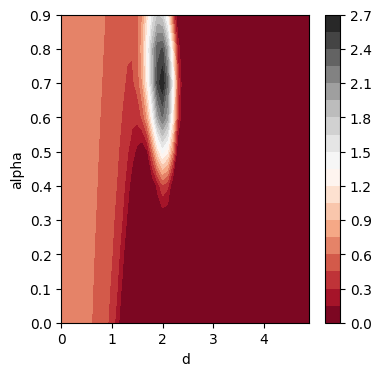

epoch 190 / 500 : loss = 0.15642604231834412


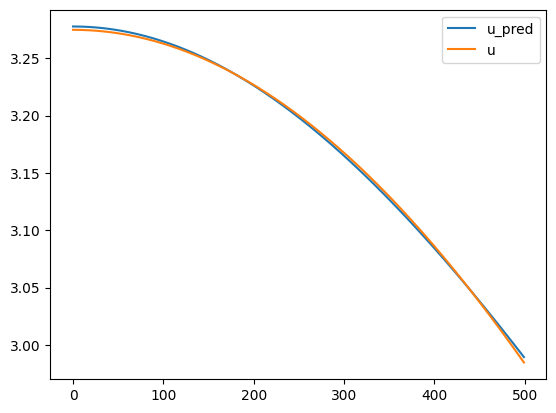

epoch 191 / 500 : loss = 0.15541313588619232
epoch 192 / 500 : loss = 0.15448623895645142
epoch 193 / 500 : loss = 0.15363813936710358
epoch 194 / 500 : loss = 0.15286409854888916


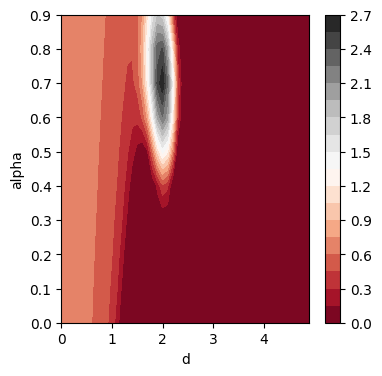

epoch 195 / 500 : loss = 0.15215721726417542


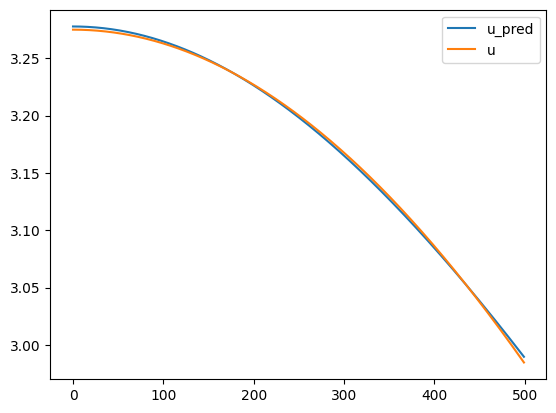

epoch 196 / 500 : loss = 0.15151338279247284
epoch 197 / 500 : loss = 0.15092651546001434
epoch 198 / 500 : loss = 0.15039300918579102
epoch 199 / 500 : loss = 0.14990776777267456


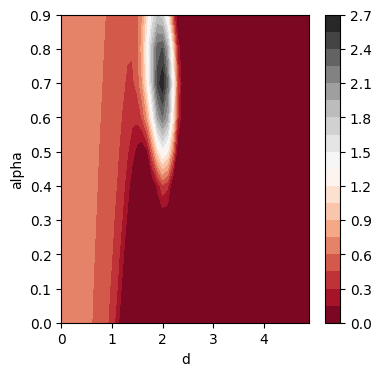

epoch 200 / 500 : loss = 0.1494670957326889


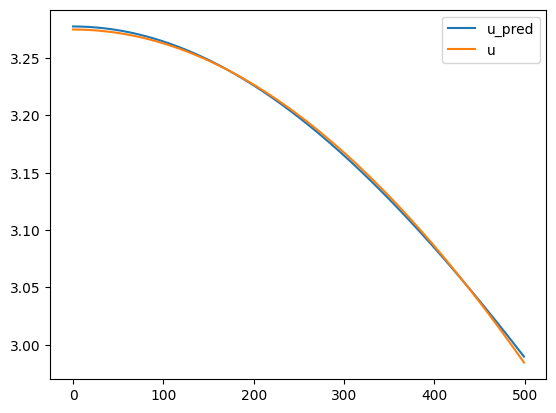

epoch 201 / 500 : loss = 0.14906729757785797
epoch 202 / 500 : loss = 0.1487048864364624
epoch 203 / 500 : loss = 0.14837691187858582
epoch 204 / 500 : loss = 0.14808031916618347


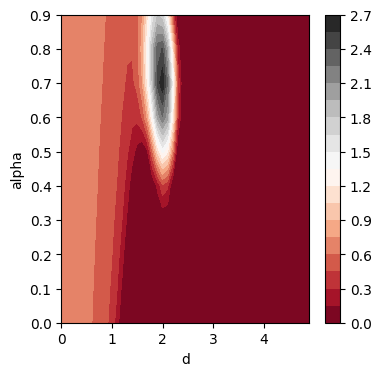

epoch 205 / 500 : loss = 0.14781223237514496


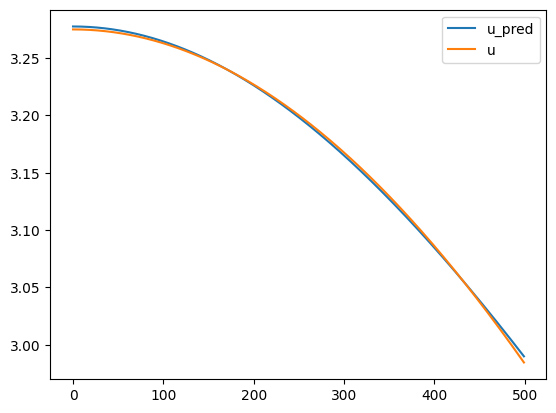

epoch 206 / 500 : loss = 0.1475701630115509
epoch 207 / 500 : loss = 0.14735223352909088
epoch 208 / 500 : loss = 0.1471557468175888
epoch 209 / 500 : loss = 0.1469789743423462


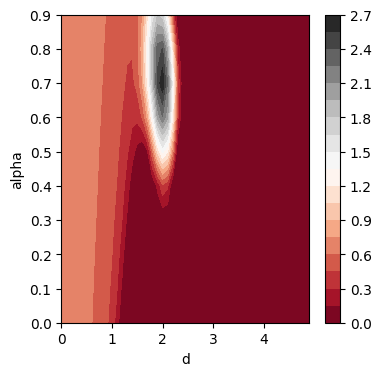

epoch 210 / 500 : loss = 0.1468202769756317


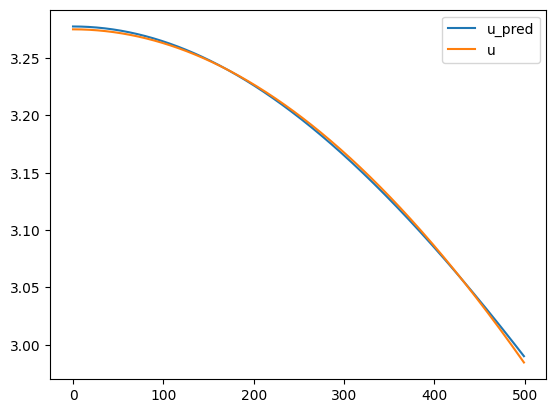

epoch 211 / 500 : loss = 0.14667797088623047
epoch 212 / 500 : loss = 0.1465502679347992
epoch 213 / 500 : loss = 0.14643582701683044
epoch 214 / 500 : loss = 0.14633390307426453


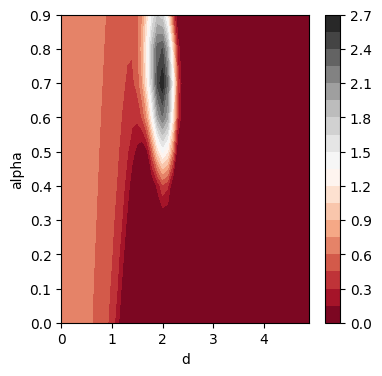

epoch 215 / 500 : loss = 0.14624284207820892


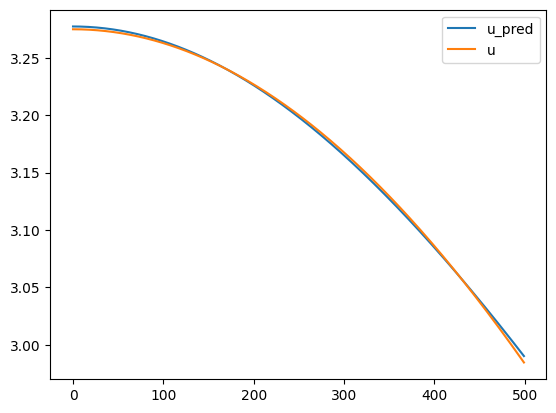

epoch 216 / 500 : loss = 0.14616119861602783
epoch 217 / 500 : loss = 0.14608880877494812
epoch 218 / 500 : loss = 0.14602449536323547
epoch 219 / 500 : loss = 0.1459667980670929


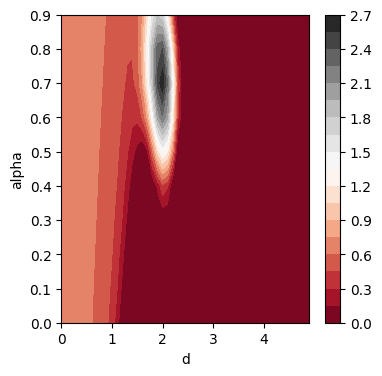

epoch 220 / 500 : loss = 0.1459156572818756


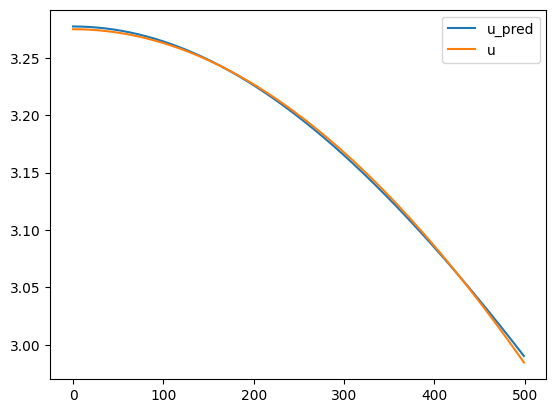

epoch 221 / 500 : loss = 0.14587081968784332
epoch 222 / 500 : loss = 0.14583104848861694
epoch 223 / 500 : loss = 0.1457957625389099
epoch 224 / 500 : loss = 0.1457642912864685


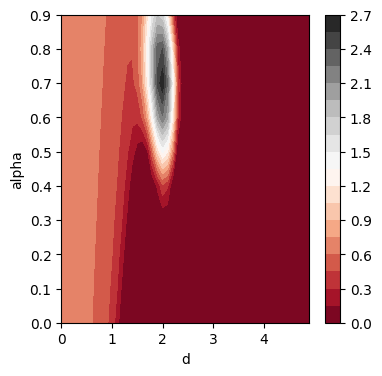

epoch 225 / 500 : loss = 0.14573660492897034


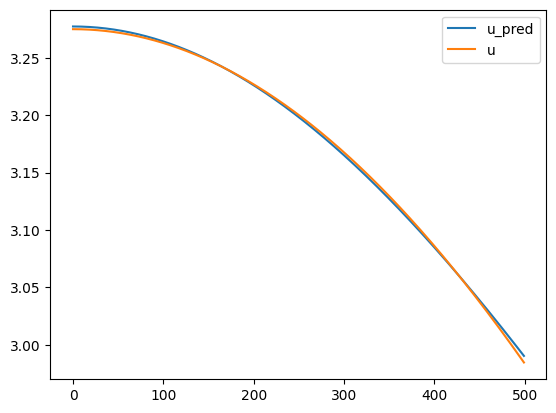

epoch 226 / 500 : loss = 0.14571267366409302
epoch 227 / 500 : loss = 0.14569109678268433
epoch 228 / 500 : loss = 0.14567208290100098
epoch 229 / 500 : loss = 0.145656019449234


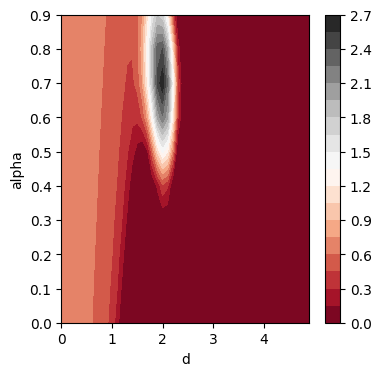

epoch 230 / 500 : loss = 0.14564120769500732


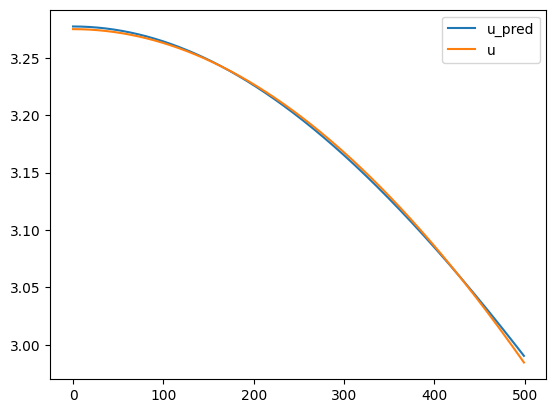

epoch 231 / 500 : loss = 0.14562873542308807
epoch 232 / 500 : loss = 0.14561772346496582
epoch 233 / 500 : loss = 0.14560770988464355
epoch 234 / 500 : loss = 0.14559903740882874


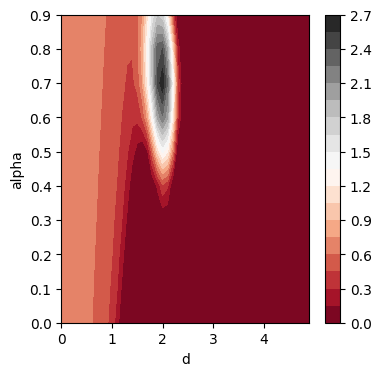

epoch 235 / 500 : loss = 0.14559131860733032


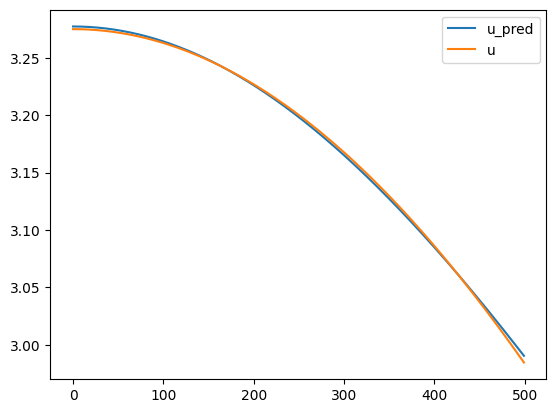

epoch 236 / 500 : loss = 0.1455850601196289
epoch 237 / 500 : loss = 0.14557905495166779
epoch 238 / 500 : loss = 0.14557360112667084
epoch 239 / 500 : loss = 0.14556916058063507


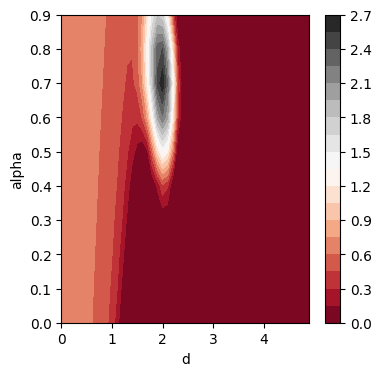

epoch 240 / 500 : loss = 0.14556509256362915


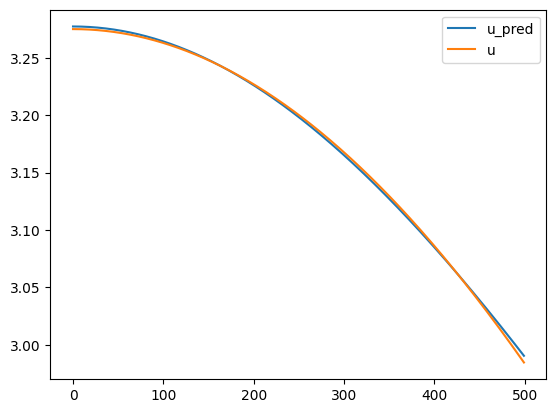

epoch 241 / 500 : loss = 0.14556154608726501
epoch 242 / 500 : loss = 0.14555802941322327
epoch 243 / 500 : loss = 0.145555317401886
epoch 244 / 500 : loss = 0.14555251598358154


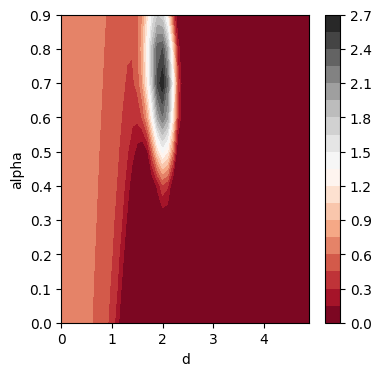

epoch 245 / 500 : loss = 0.14555025100708008


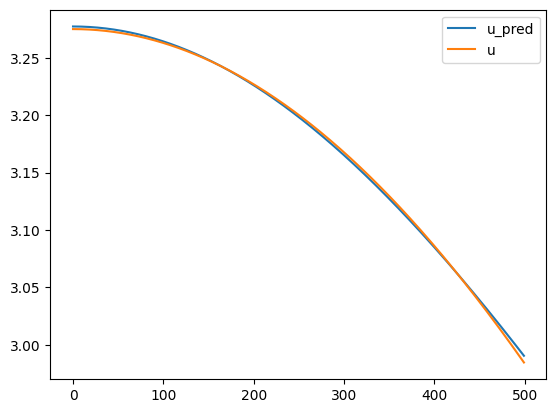

epoch 246 / 500 : loss = 0.1455477625131607
epoch 247 / 500 : loss = 0.14554578065872192
epoch 248 / 500 : loss = 0.14554369449615479
epoch 249 / 500 : loss = 0.14554236829280853


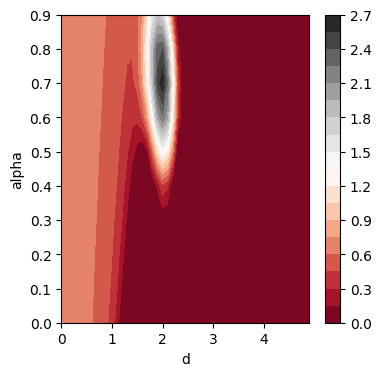

epoch 250 / 500 : loss = 0.1455400437116623


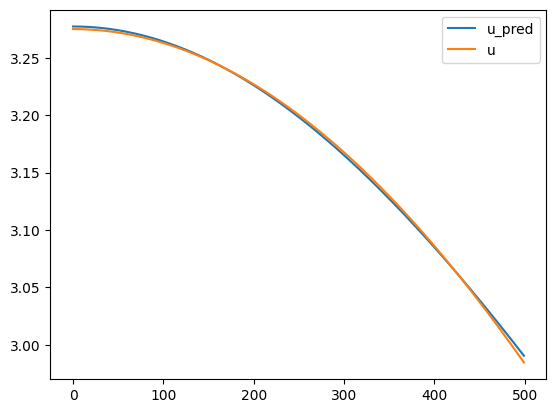

epoch 251 / 500 : loss = 0.14553840458393097
epoch 252 / 500 : loss = 0.14553692936897278
epoch 253 / 500 : loss = 0.145534947514534
epoch 254 / 500 : loss = 0.14553368091583252


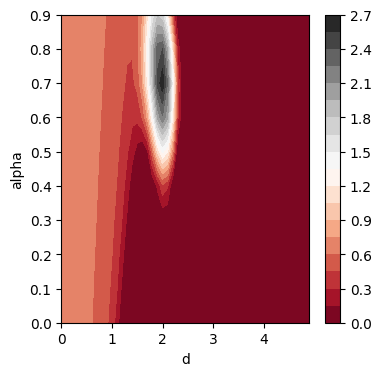

epoch 255 / 500 : loss = 0.14553198218345642


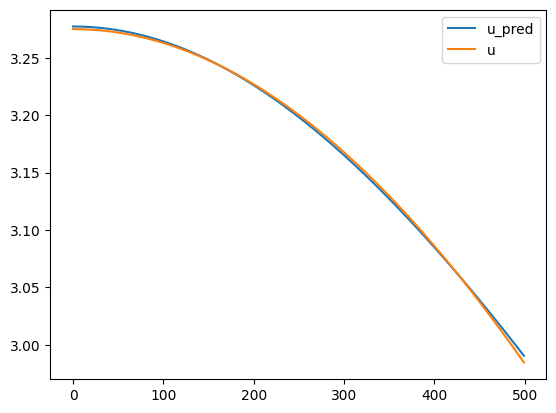

epoch 256 / 500 : loss = 0.1455303281545639
epoch 257 / 500 : loss = 0.14552907645702362
epoch 258 / 500 : loss = 0.14552755653858185
epoch 259 / 500 : loss = 0.14552587270736694


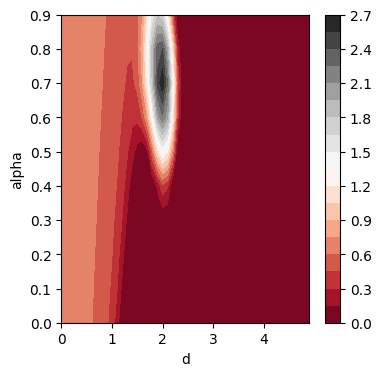

epoch 260 / 500 : loss = 0.1455245167016983


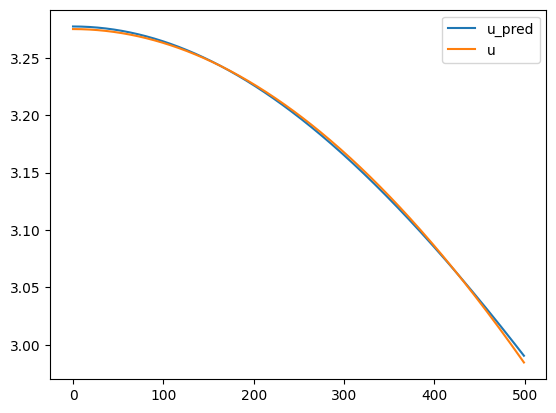

epoch 261 / 500 : loss = 0.14552253484725952
epoch 262 / 500 : loss = 0.14552129805088043
epoch 263 / 500 : loss = 0.14551950991153717
epoch 264 / 500 : loss = 0.14551812410354614


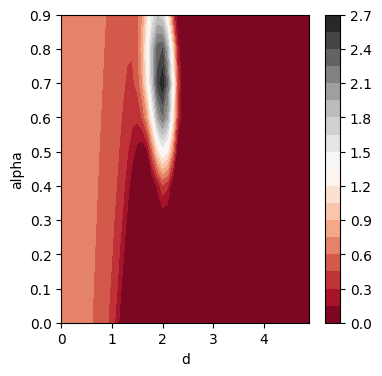

epoch 265 / 500 : loss = 0.1455165296792984


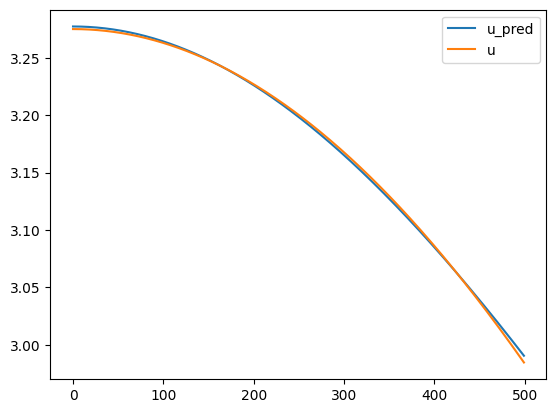

epoch 266 / 500 : loss = 0.14551469683647156
epoch 267 / 500 : loss = 0.14551323652267456
epoch 268 / 500 : loss = 0.14551150798797607
epoch 269 / 500 : loss = 0.14550946652889252


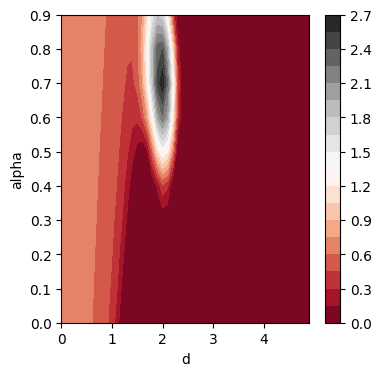

epoch 270 / 500 : loss = 0.1455083191394806


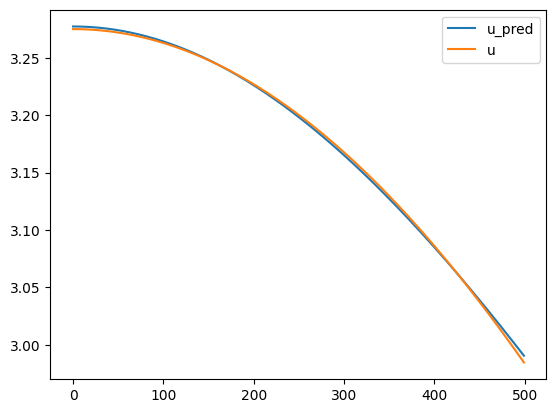

epoch 271 / 500 : loss = 0.14550654590129852
epoch 272 / 500 : loss = 0.1455046534538269
epoch 273 / 500 : loss = 0.14550331234931946
epoch 274 / 500 : loss = 0.14550115168094635


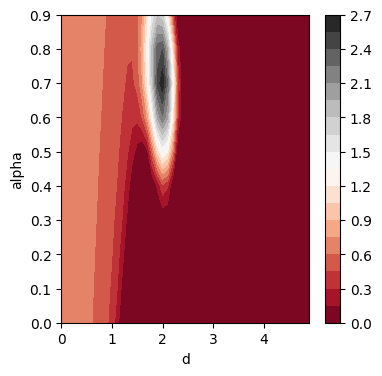

epoch 275 / 500 : loss = 0.145499587059021


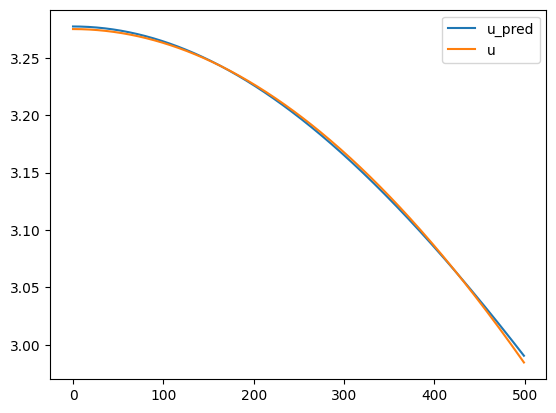

epoch 276 / 500 : loss = 0.14549796283245087
epoch 277 / 500 : loss = 0.14549624919891357
epoch 278 / 500 : loss = 0.14549443125724792
epoch 279 / 500 : loss = 0.1454925388097763


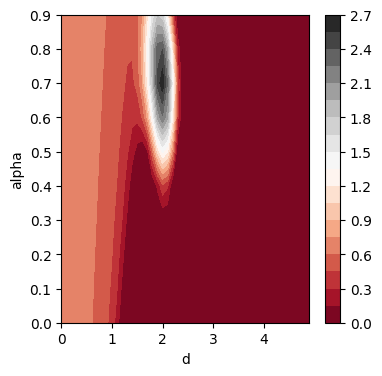

epoch 280 / 500 : loss = 0.1454911231994629


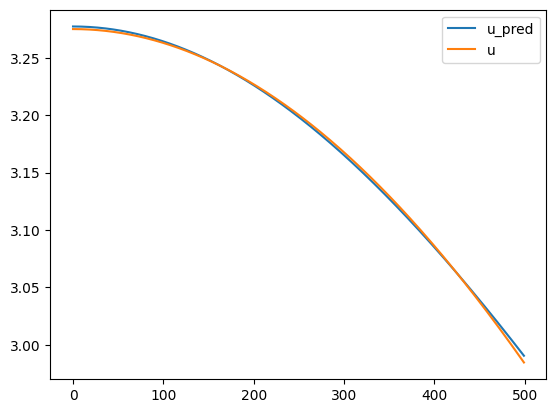

epoch 281 / 500 : loss = 0.14548934996128082
epoch 282 / 500 : loss = 0.14548781514167786
epoch 283 / 500 : loss = 0.14548590779304504
epoch 284 / 500 : loss = 0.14548395574092865


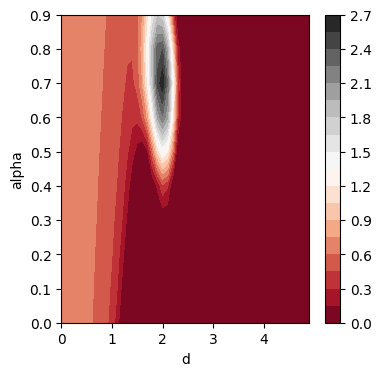

epoch 285 / 500 : loss = 0.14548246562480927


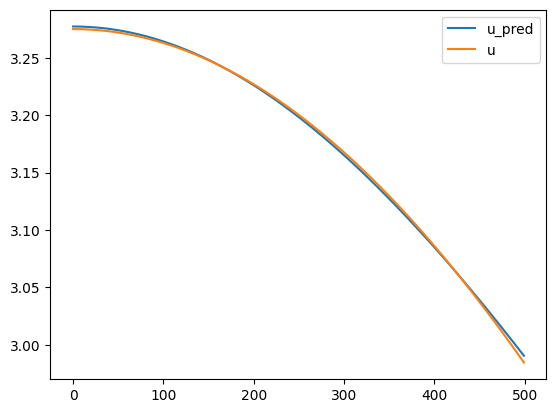

epoch 286 / 500 : loss = 0.14548060297966003
epoch 287 / 500 : loss = 0.14547869563102722
epoch 288 / 500 : loss = 0.14547693729400635
epoch 289 / 500 : loss = 0.14547522366046906


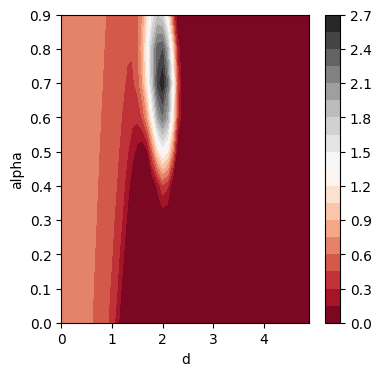

epoch 290 / 500 : loss = 0.1454734057188034


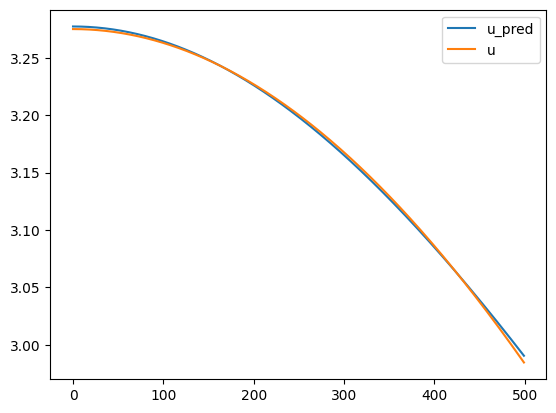

epoch 291 / 500 : loss = 0.14547207951545715
epoch 292 / 500 : loss = 0.14547012746334076
epoch 293 / 500 : loss = 0.14546805620193481
epoch 294 / 500 : loss = 0.14546646177768707


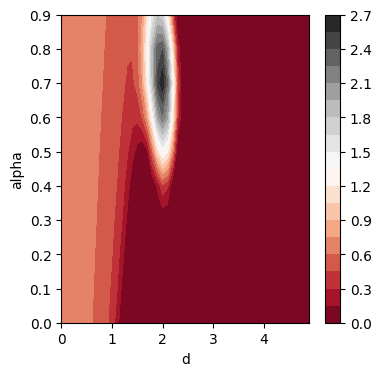

epoch 295 / 500 : loss = 0.14546474814414978


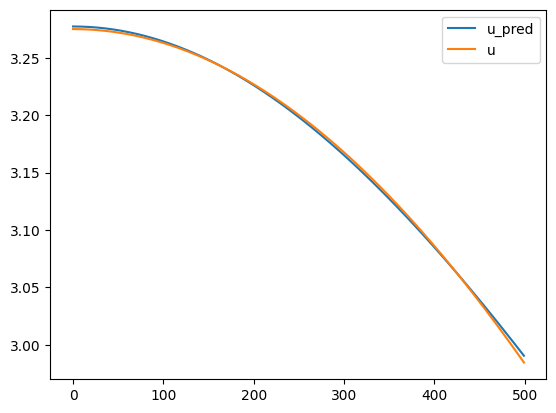

epoch 296 / 500 : loss = 0.14546296000480652
epoch 297 / 500 : loss = 0.14546135067939758
epoch 298 / 500 : loss = 0.1454593539237976
epoch 299 / 500 : loss = 0.14545747637748718


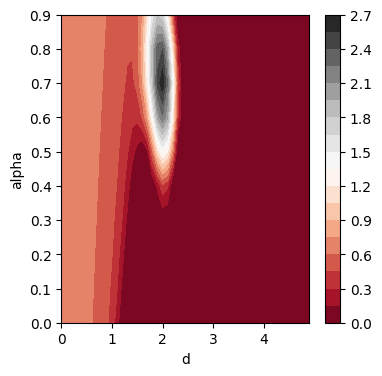

epoch 300 / 500 : loss = 0.1454559564590454


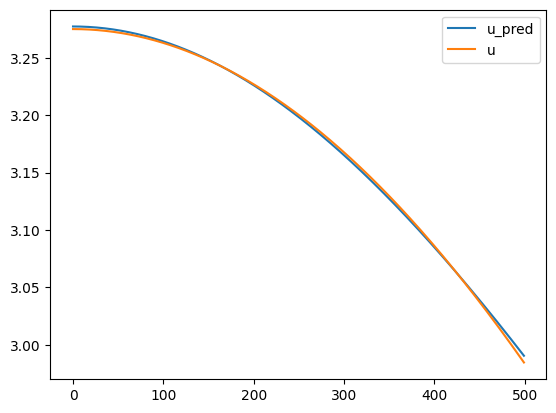

epoch 301 / 500 : loss = 0.14545416831970215
epoch 302 / 500 : loss = 0.14545240998268127
epoch 303 / 500 : loss = 0.145450621843338
epoch 304 / 500 : loss = 0.1454487144947052


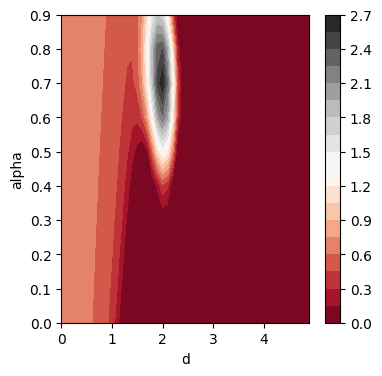

epoch 305 / 500 : loss = 0.14544713497161865


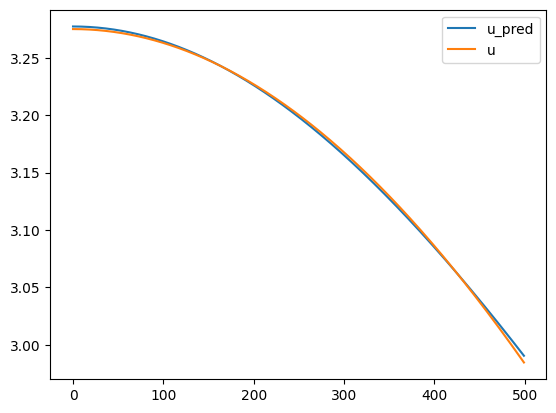

epoch 306 / 500 : loss = 0.14544525742530823
epoch 307 / 500 : loss = 0.14544345438480377
epoch 308 / 500 : loss = 0.1454417109489441
epoch 309 / 500 : loss = 0.14543983340263367


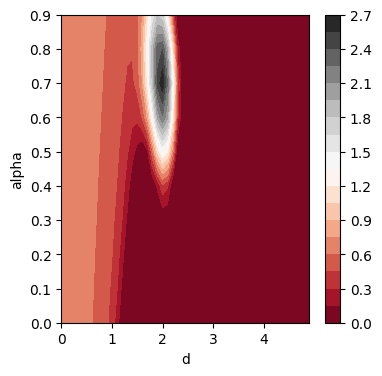

epoch 310 / 500 : loss = 0.14543786644935608


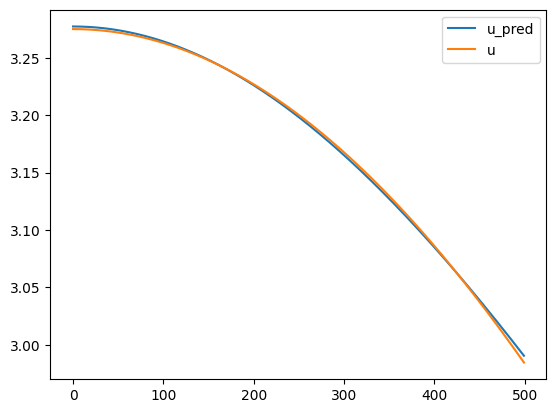

epoch 311 / 500 : loss = 0.14543646574020386
epoch 312 / 500 : loss = 0.14543452858924866
epoch 313 / 500 : loss = 0.14543277025222778
epoch 314 / 500 : loss = 0.14543093740940094


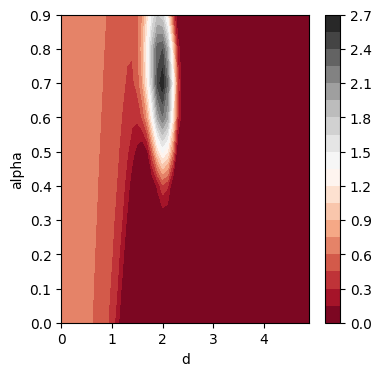

epoch 315 / 500 : loss = 0.14542901515960693


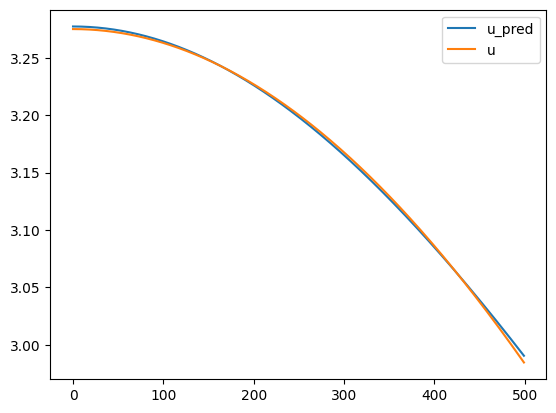

epoch 316 / 500 : loss = 0.14542707800865173
epoch 317 / 500 : loss = 0.14542526006698608
epoch 318 / 500 : loss = 0.1454235017299652
epoch 319 / 500 : loss = 0.14542175829410553


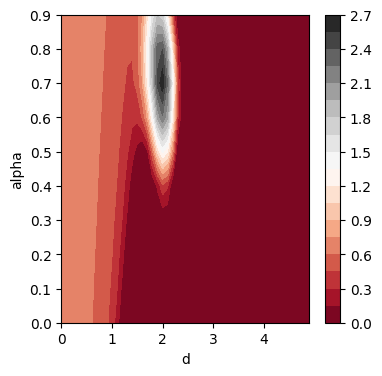

epoch 320 / 500 : loss = 0.14541979134082794


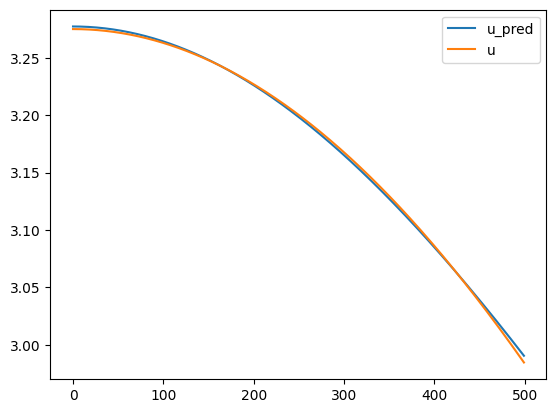

epoch 321 / 500 : loss = 0.1454179883003235
epoch 322 / 500 : loss = 0.1454162448644638
epoch 323 / 500 : loss = 0.14541442692279816
epoch 324 / 500 : loss = 0.1454124003648758


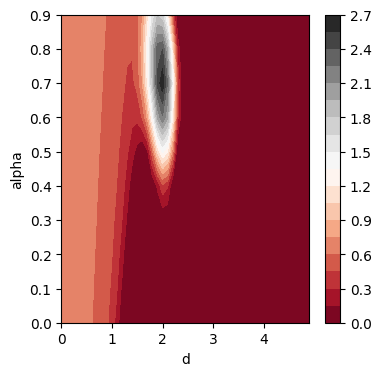

epoch 325 / 500 : loss = 0.14541089534759521


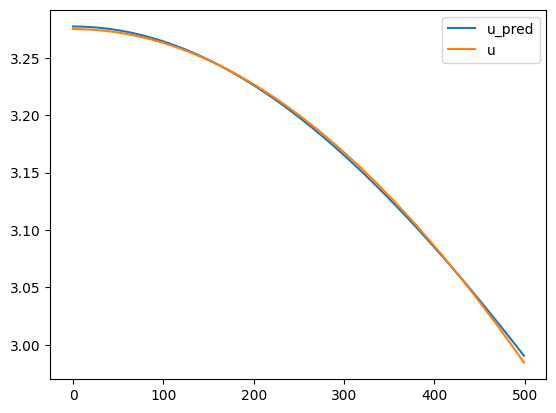

epoch 326 / 500 : loss = 0.14540895819664001
epoch 327 / 500 : loss = 0.14540702104568481
epoch 328 / 500 : loss = 0.14540491998195648
epoch 329 / 500 : loss = 0.14540332555770874


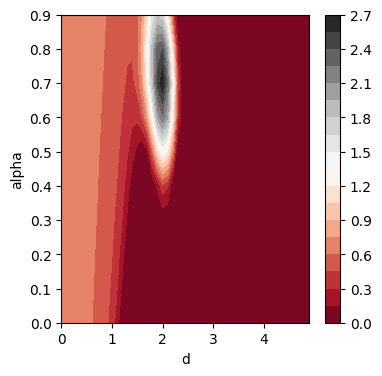

epoch 330 / 500 : loss = 0.14540131390094757


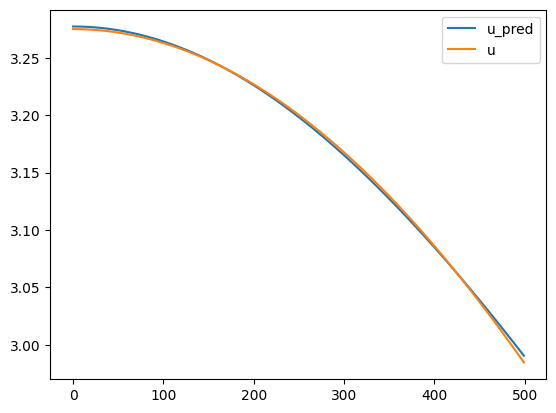

epoch 331 / 500 : loss = 0.14539939165115356
epoch 332 / 500 : loss = 0.14539754390716553
epoch 333 / 500 : loss = 0.14539559185504913
epoch 334 / 500 : loss = 0.14539417624473572


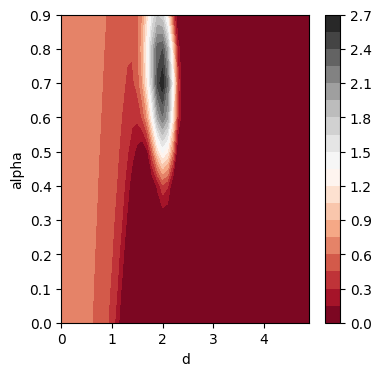

epoch 335 / 500 : loss = 0.14539213478565216


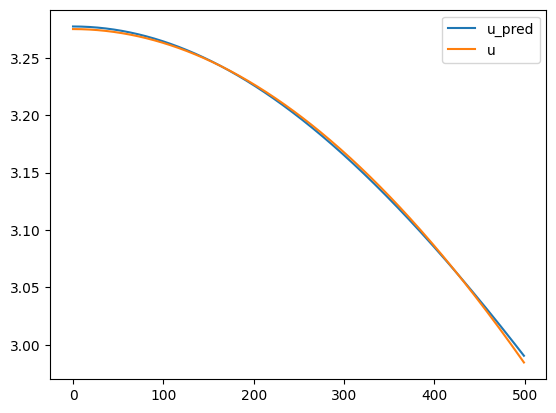

epoch 336 / 500 : loss = 0.14539021253585815
epoch 337 / 500 : loss = 0.1453881561756134
epoch 338 / 500 : loss = 0.14538618922233582
epoch 339 / 500 : loss = 0.1453845351934433


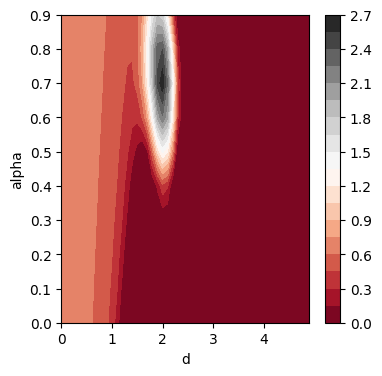

epoch 340 / 500 : loss = 0.14538250863552094


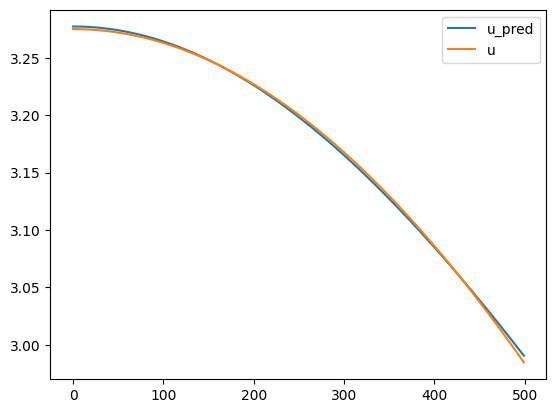

epoch 341 / 500 : loss = 0.14538073539733887
epoch 342 / 500 : loss = 0.1453786939382553
epoch 343 / 500 : loss = 0.1453769952058792
epoch 344 / 500 : loss = 0.14537513256072998


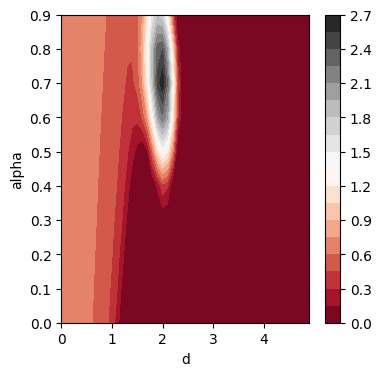

epoch 345 / 500 : loss = 0.14537303149700165


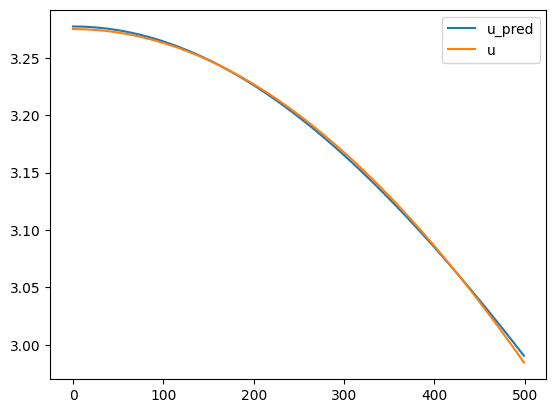

epoch 346 / 500 : loss = 0.1453712284564972
epoch 347 / 500 : loss = 0.145369291305542
epoch 348 / 500 : loss = 0.14536720514297485
epoch 349 / 500 : loss = 0.14536535739898682


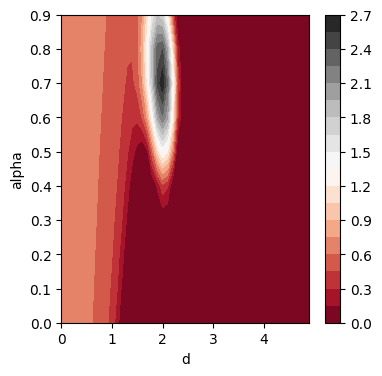

epoch 350 / 500 : loss = 0.145363450050354


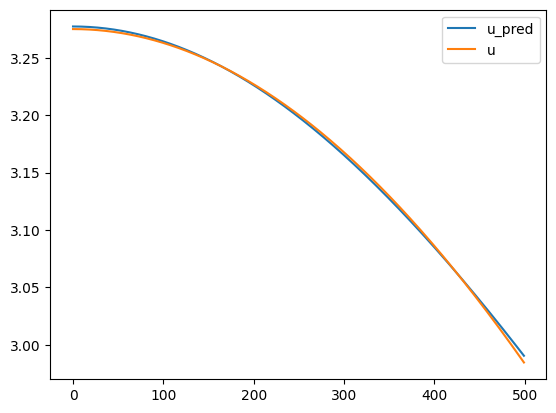

epoch 351 / 500 : loss = 0.14536124467849731
epoch 352 / 500 : loss = 0.14535962045192719
epoch 353 / 500 : loss = 0.14535777270793915
epoch 354 / 500 : loss = 0.14535574615001678


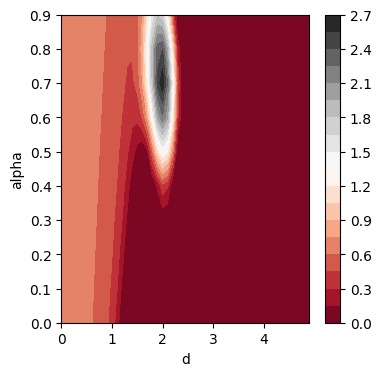

epoch 355 / 500 : loss = 0.1453539878129959


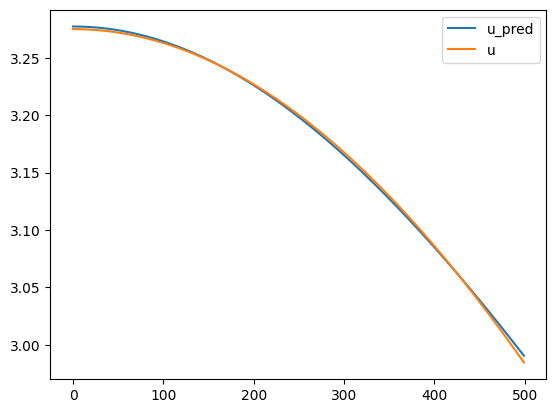

epoch 356 / 500 : loss = 0.14535193145275116
epoch 357 / 500 : loss = 0.14534978568553925
epoch 358 / 500 : loss = 0.14534804224967957
epoch 359 / 500 : loss = 0.1453462839126587


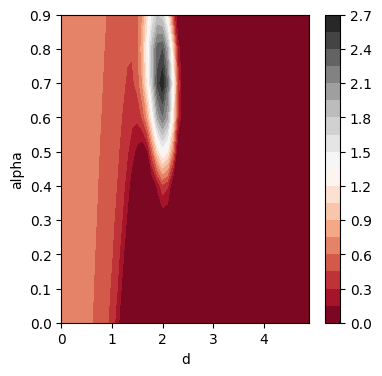

epoch 360 / 500 : loss = 0.14534418284893036


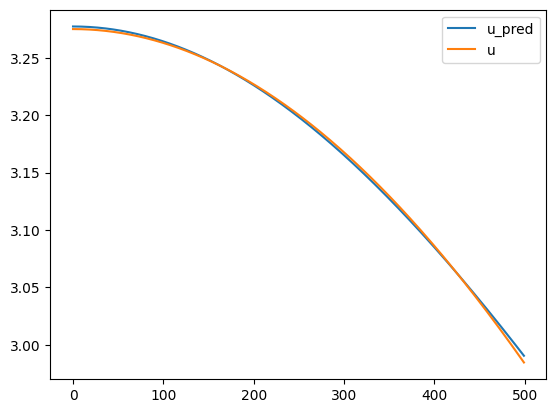

epoch 361 / 500 : loss = 0.14534205198287964
epoch 362 / 500 : loss = 0.14534005522727966
epoch 363 / 500 : loss = 0.1453380584716797
epoch 364 / 500 : loss = 0.14533615112304688


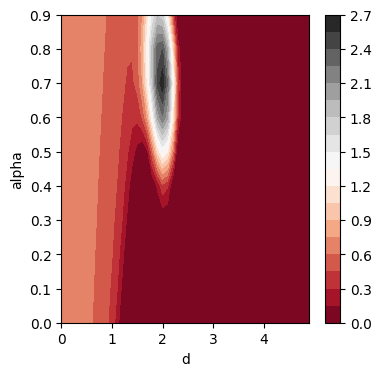

epoch 365 / 500 : loss = 0.1453339010477066


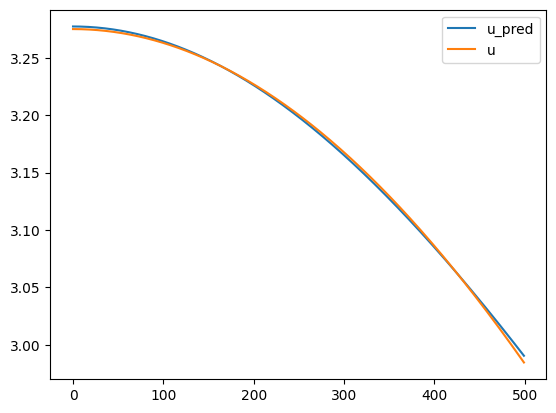

epoch 366 / 500 : loss = 0.1453322470188141
epoch 367 / 500 : loss = 0.1453302800655365
epoch 368 / 500 : loss = 0.14532825350761414
epoch 369 / 500 : loss = 0.14532630145549774


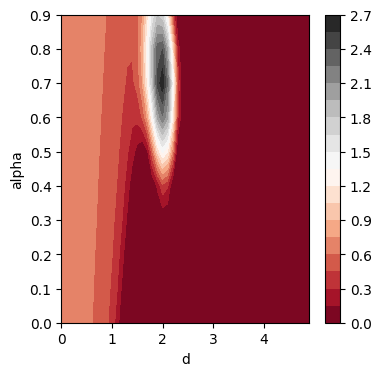

epoch 370 / 500 : loss = 0.14532411098480225


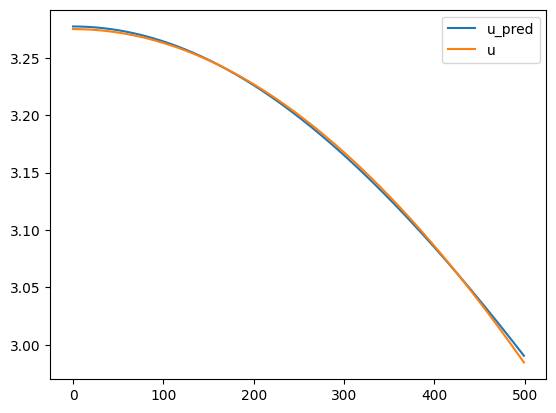

epoch 371 / 500 : loss = 0.14532221853733063
epoch 372 / 500 : loss = 0.1453201174736023
epoch 373 / 500 : loss = 0.14531825482845306
epoch 374 / 500 : loss = 0.14531630277633667


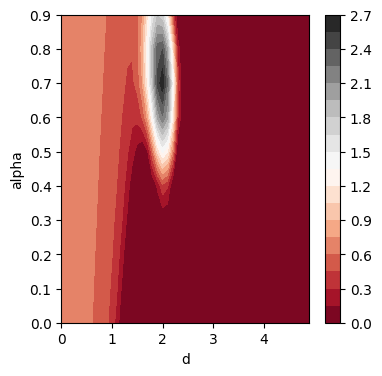

epoch 375 / 500 : loss = 0.14531433582305908


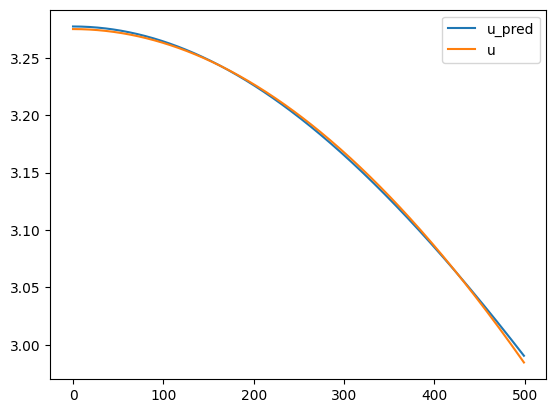

epoch 376 / 500 : loss = 0.14531239867210388
epoch 377 / 500 : loss = 0.14531013369560242
epoch 378 / 500 : loss = 0.14530804753303528
epoch 379 / 500 : loss = 0.14530640840530396


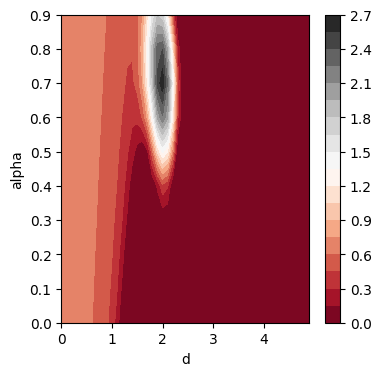

epoch 380 / 500 : loss = 0.1453043818473816


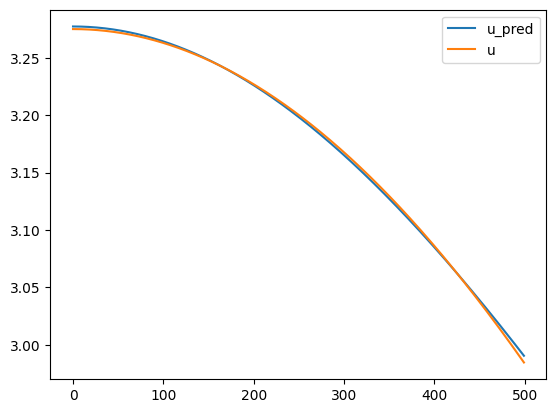

epoch 381 / 500 : loss = 0.14530214667320251
epoch 382 / 500 : loss = 0.14530032873153687
epoch 383 / 500 : loss = 0.14529818296432495
epoch 384 / 500 : loss = 0.14529620110988617


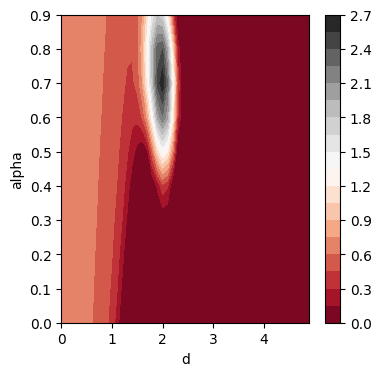

epoch 385 / 500 : loss = 0.14529412984848022


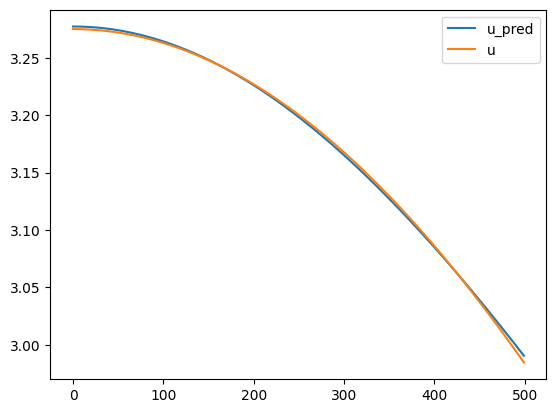

epoch 386 / 500 : loss = 0.14529193937778473
epoch 387 / 500 : loss = 0.14529001712799072
epoch 388 / 500 : loss = 0.14528807997703552
epoch 389 / 500 : loss = 0.14528612792491913


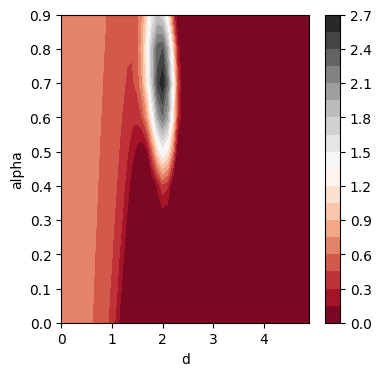

epoch 390 / 500 : loss = 0.14528366923332214


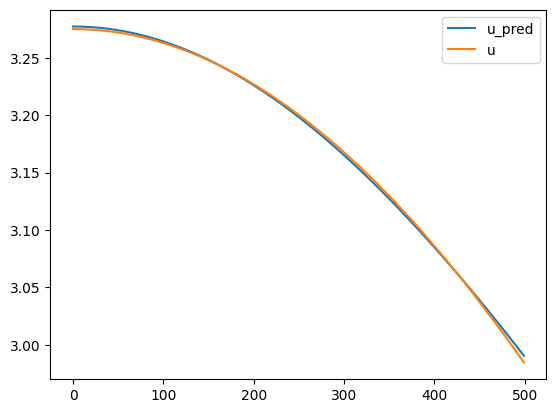

epoch 391 / 500 : loss = 0.1452818214893341
epoch 392 / 500 : loss = 0.1452798694372177
epoch 393 / 500 : loss = 0.14527763426303864
epoch 394 / 500 : loss = 0.1452757865190506


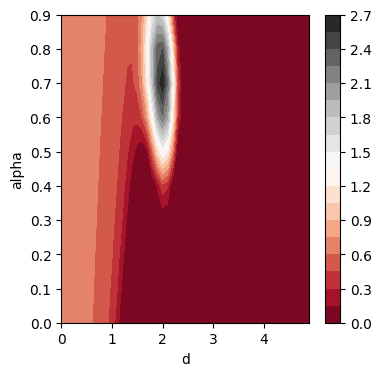

epoch 395 / 500 : loss = 0.14527370035648346


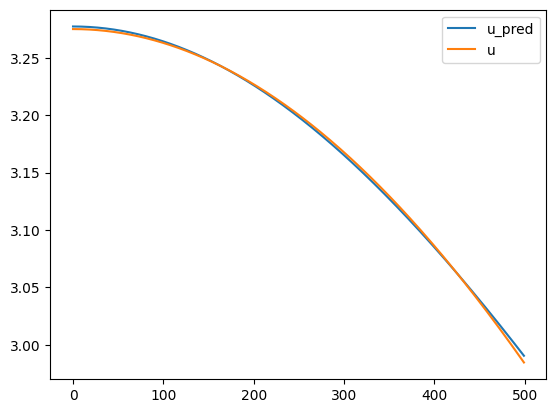

epoch 396 / 500 : loss = 0.14527170360088348
epoch 397 / 500 : loss = 0.145269513130188
epoch 398 / 500 : loss = 0.14526720345020294
epoch 399 / 500 : loss = 0.1452654004096985


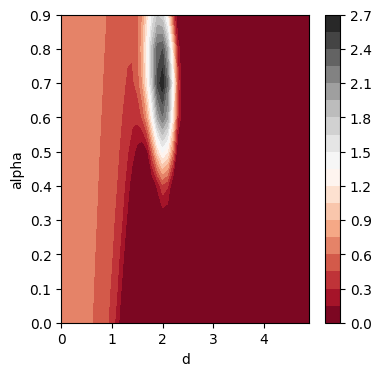

epoch 400 / 500 : loss = 0.1452634632587433


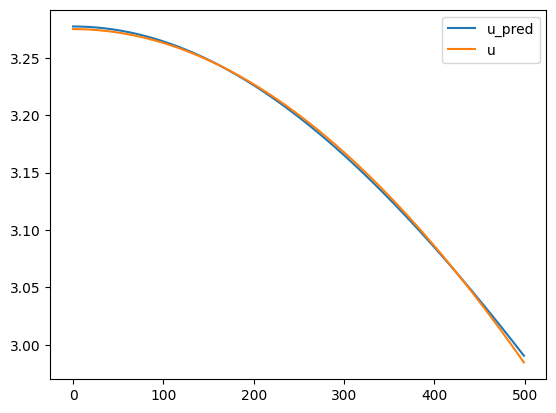

epoch 401 / 500 : loss = 0.1452612280845642
epoch 402 / 500 : loss = 0.14525899291038513
epoch 403 / 500 : loss = 0.1452569216489792
epoch 404 / 500 : loss = 0.14525482058525085


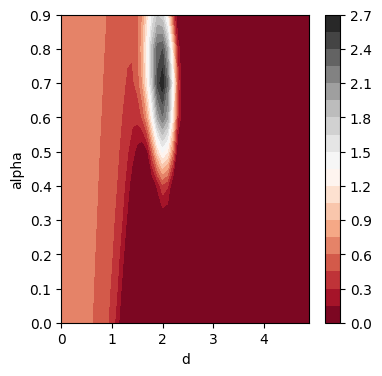

epoch 405 / 500 : loss = 0.14525261521339417


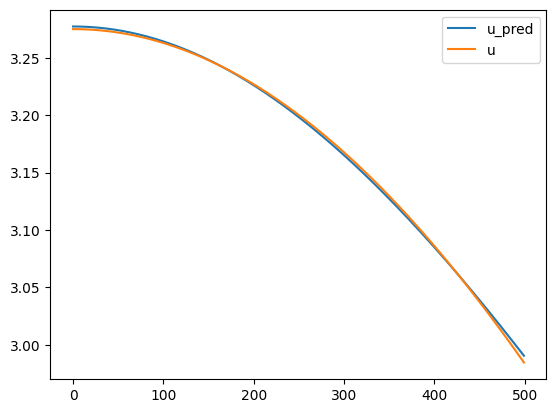

epoch 406 / 500 : loss = 0.1452508270740509
epoch 407 / 500 : loss = 0.14524848759174347
epoch 408 / 500 : loss = 0.14524652063846588
epoch 409 / 500 : loss = 0.14524449408054352


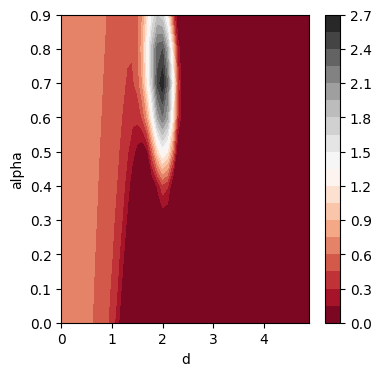

epoch 410 / 500 : loss = 0.14524221420288086


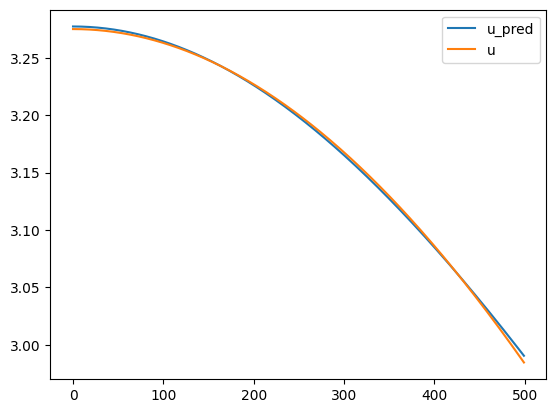

epoch 411 / 500 : loss = 0.1452399343252182
epoch 412 / 500 : loss = 0.14523783326148987
epoch 413 / 500 : loss = 0.14523613452911377
epoch 414 / 500 : loss = 0.14523398876190186


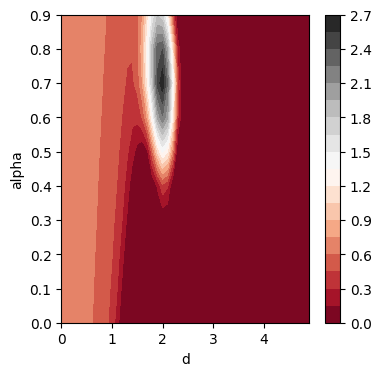

epoch 415 / 500 : loss = 0.1452314853668213


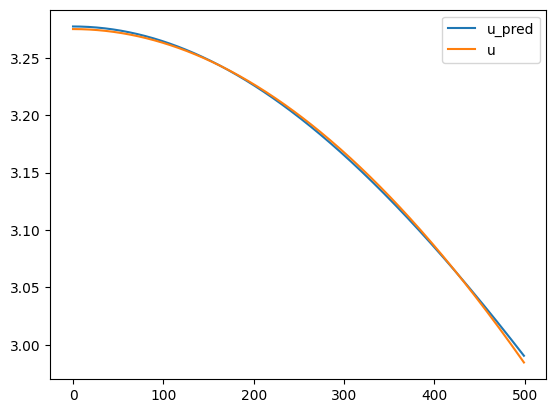

epoch 416 / 500 : loss = 0.14522942900657654
epoch 417 / 500 : loss = 0.14522750675678253
epoch 418 / 500 : loss = 0.145224928855896
epoch 419 / 500 : loss = 0.14522309601306915


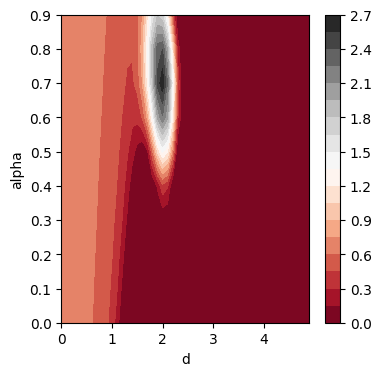

epoch 420 / 500 : loss = 0.14522108435630798


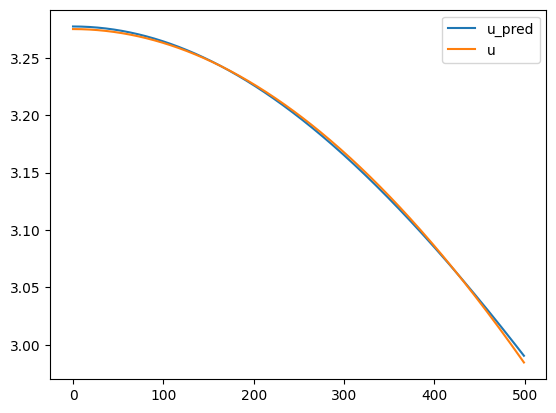

epoch 421 / 500 : loss = 0.14521870017051697
epoch 422 / 500 : loss = 0.14521656930446625
epoch 423 / 500 : loss = 0.14521491527557373
epoch 424 / 500 : loss = 0.14521260559558868


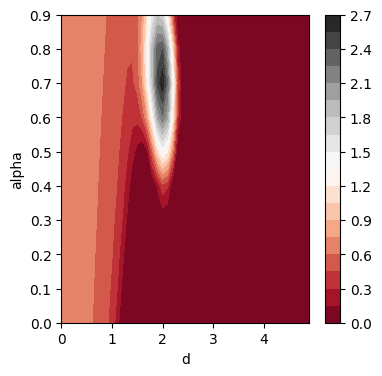

epoch 425 / 500 : loss = 0.1452101469039917


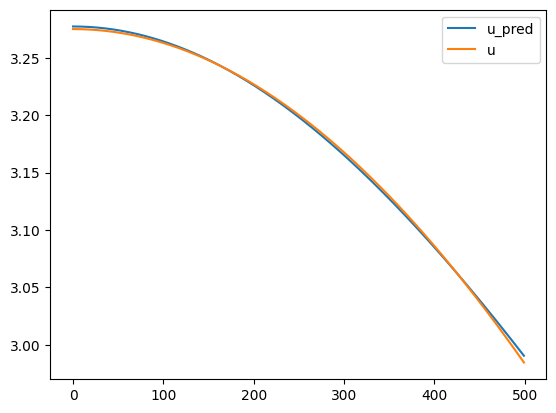

epoch 426 / 500 : loss = 0.1452082097530365
epoch 427 / 500 : loss = 0.14520584046840668
epoch 428 / 500 : loss = 0.1452036201953888
epoch 429 / 500 : loss = 0.14520154893398285


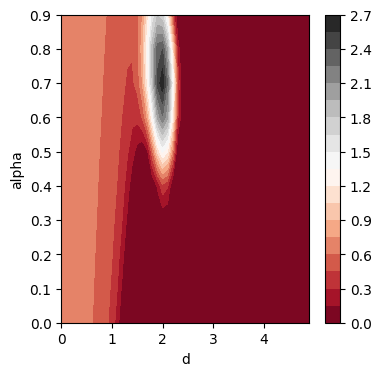

epoch 430 / 500 : loss = 0.14519944787025452


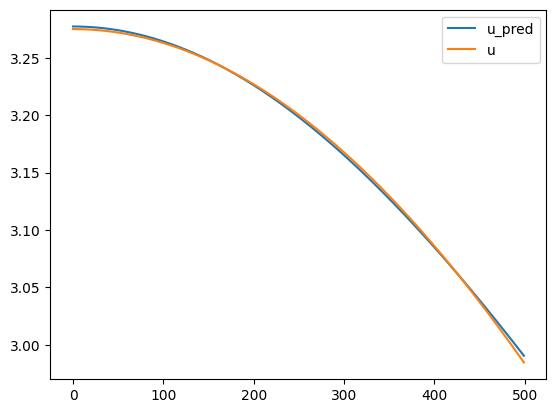

epoch 431 / 500 : loss = 0.14519764482975006
epoch 432 / 500 : loss = 0.1451951414346695
epoch 433 / 500 : loss = 0.14519280195236206
epoch 434 / 500 : loss = 0.1451907455921173


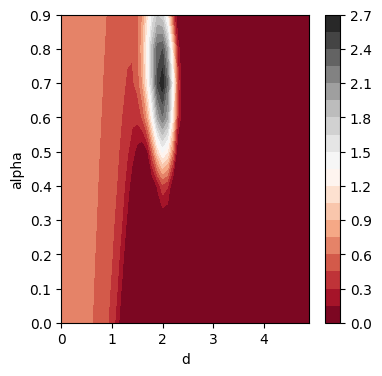

epoch 435 / 500 : loss = 0.1451885998249054


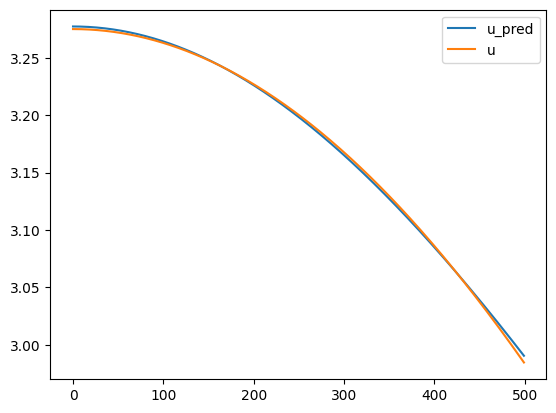

epoch 436 / 500 : loss = 0.1451863795518875
epoch 437 / 500 : loss = 0.14518415927886963
epoch 438 / 500 : loss = 0.14518193900585175
epoch 439 / 500 : loss = 0.1451796293258667


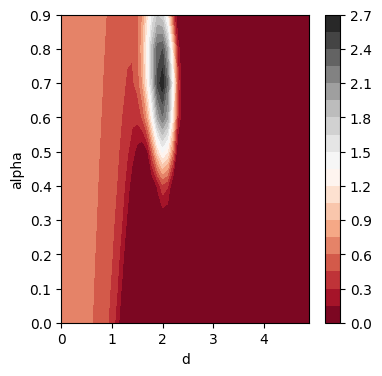

epoch 440 / 500 : loss = 0.1451779305934906


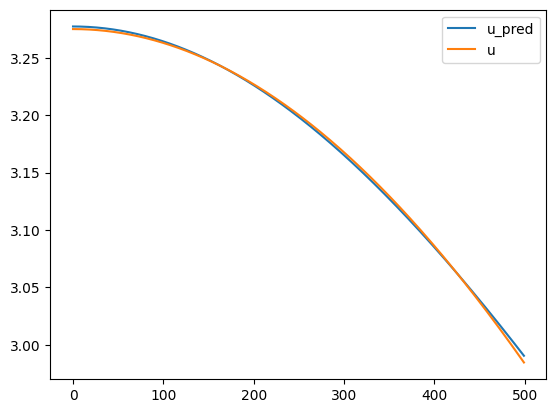

epoch 441 / 500 : loss = 0.145175501704216
epoch 442 / 500 : loss = 0.14517337083816528
epoch 443 / 500 : loss = 0.14517071843147278
epoch 444 / 500 : loss = 0.14516910910606384


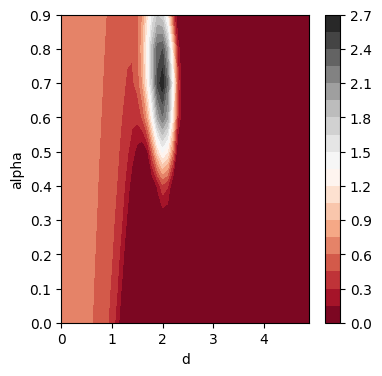

epoch 445 / 500 : loss = 0.14516672492027283


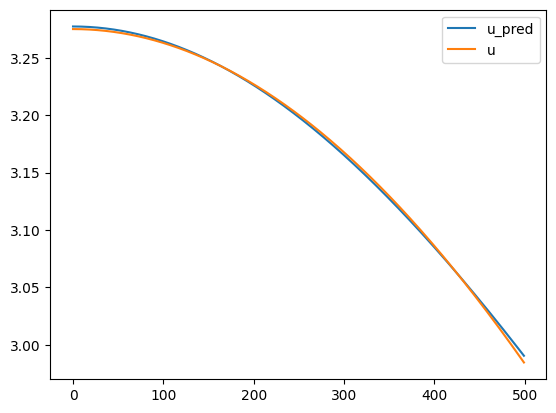

epoch 446 / 500 : loss = 0.14516456425189972
epoch 447 / 500 : loss = 0.1451621651649475
epoch 448 / 500 : loss = 0.1451602578163147
epoch 449 / 500 : loss = 0.14515754580497742


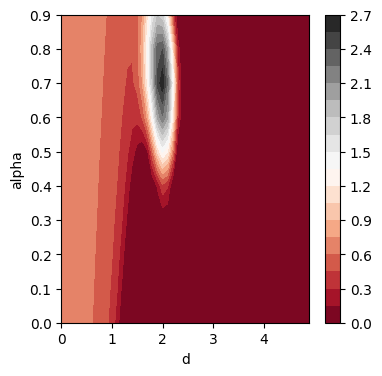

epoch 450 / 500 : loss = 0.1451556384563446


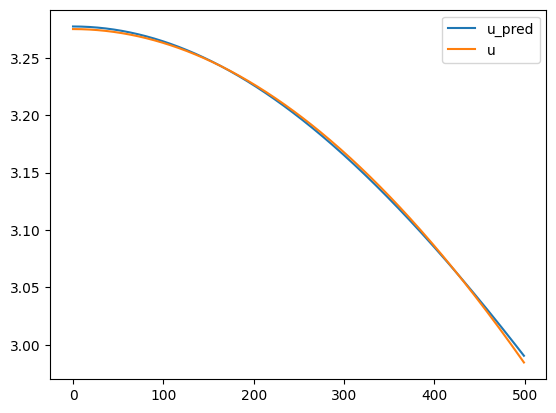

epoch 451 / 500 : loss = 0.14515317976474762
epoch 452 / 500 : loss = 0.1451510190963745
epoch 453 / 500 : loss = 0.14514879882335663
epoch 454 / 500 : loss = 0.1451464146375656


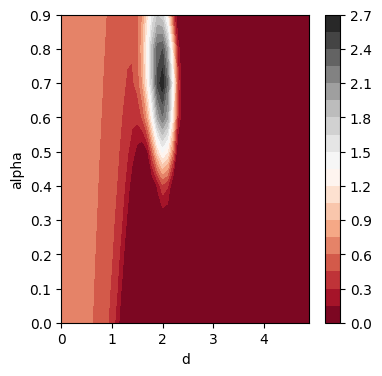

epoch 455 / 500 : loss = 0.14514386653900146


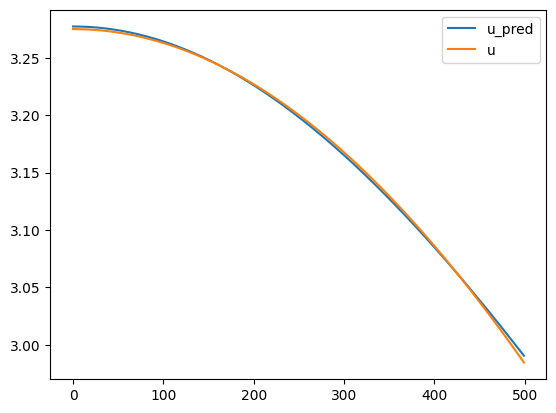

epoch 456 / 500 : loss = 0.14514204859733582
epoch 457 / 500 : loss = 0.14514008164405823
epoch 458 / 500 : loss = 0.14513765275478363
epoch 459 / 500 : loss = 0.14513513445854187


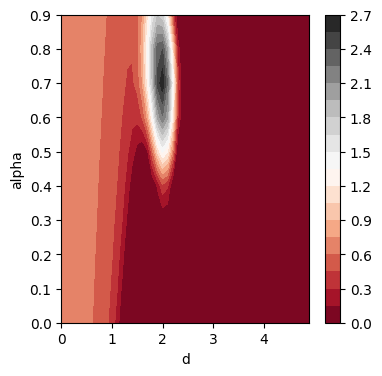

epoch 460 / 500 : loss = 0.14513282477855682


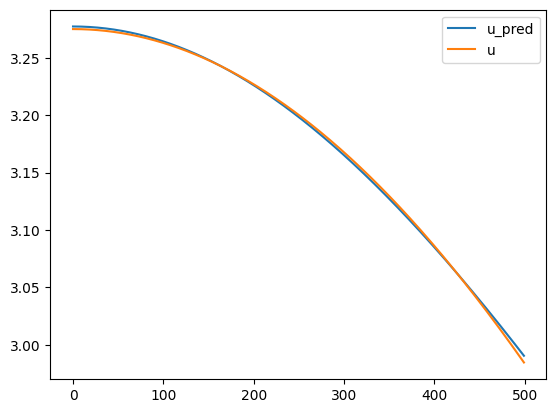

epoch 461 / 500 : loss = 0.14513085782527924
epoch 462 / 500 : loss = 0.14512841403484344
epoch 463 / 500 : loss = 0.14512617886066437
epoch 464 / 500 : loss = 0.14512382447719574


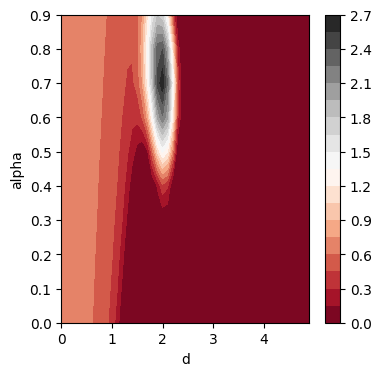

epoch 465 / 500 : loss = 0.1451217234134674


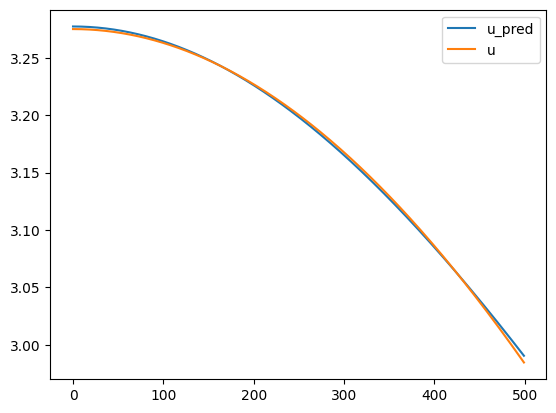

epoch 466 / 500 : loss = 0.14511936902999878
epoch 467 / 500 : loss = 0.1451168656349182
epoch 468 / 500 : loss = 0.14511480927467346
epoch 469 / 500 : loss = 0.14511236548423767


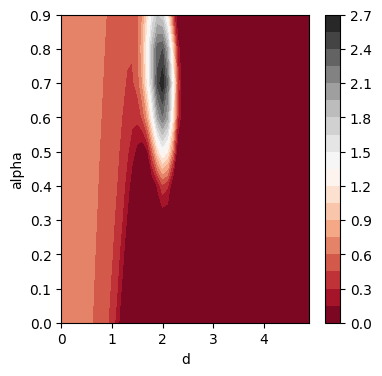

epoch 470 / 500 : loss = 0.14511039853096008


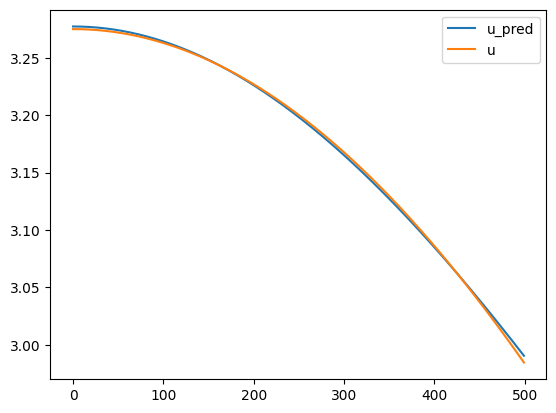

epoch 471 / 500 : loss = 0.14510801434516907
epoch 472 / 500 : loss = 0.14510557055473328
epoch 473 / 500 : loss = 0.14510340988636017
epoch 474 / 500 : loss = 0.1451011598110199


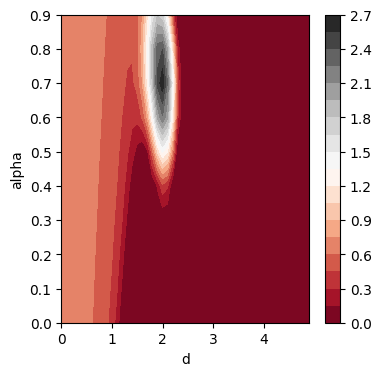

epoch 475 / 500 : loss = 0.1450987607240677


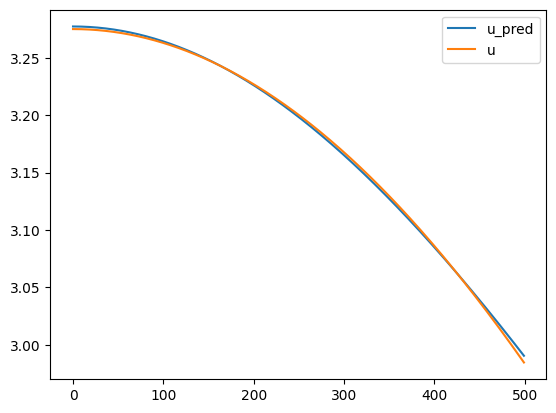

epoch 476 / 500 : loss = 0.14509642124176025
epoch 477 / 500 : loss = 0.14509406685829163
epoch 478 / 500 : loss = 0.1450919210910797
epoch 479 / 500 : loss = 0.14508964121341705


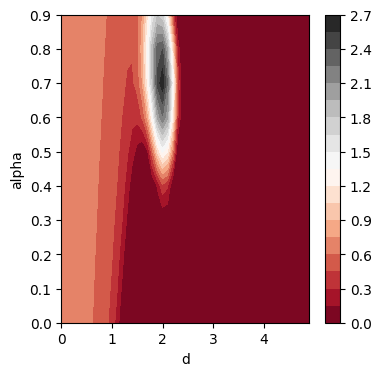

epoch 480 / 500 : loss = 0.14508721232414246


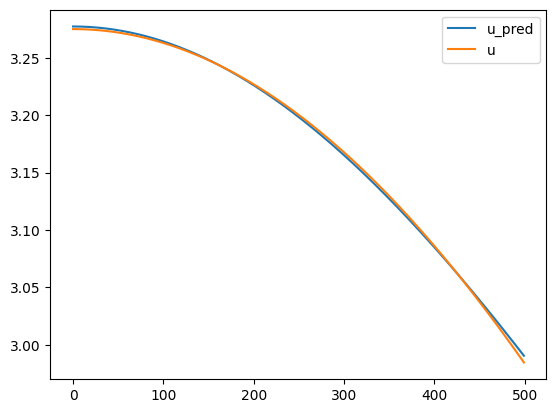

epoch 481 / 500 : loss = 0.1450847089290619
epoch 482 / 500 : loss = 0.1450825184583664
epoch 483 / 500 : loss = 0.14508047699928284
epoch 484 / 500 : loss = 0.14507801830768585


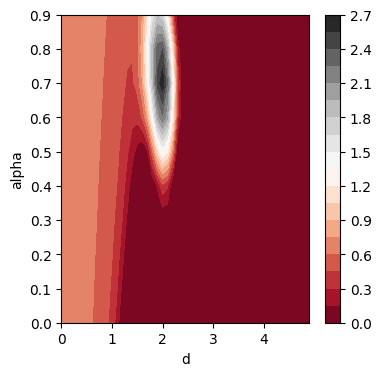

epoch 485 / 500 : loss = 0.14507558941841125


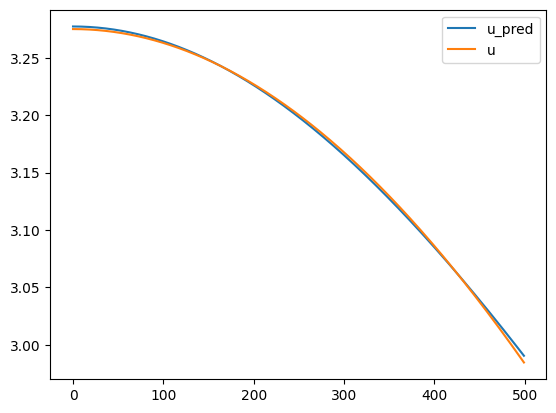

epoch 486 / 500 : loss = 0.14507336914539337
epoch 487 / 500 : loss = 0.14507097005844116
epoch 488 / 500 : loss = 0.14506864547729492
epoch 489 / 500 : loss = 0.14506608247756958


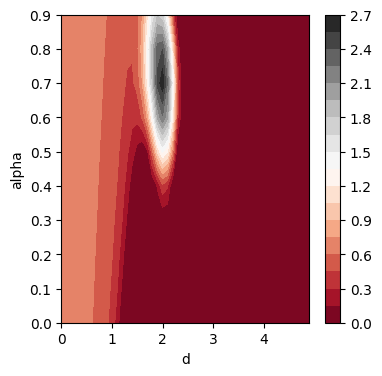

epoch 490 / 500 : loss = 0.14506392180919647


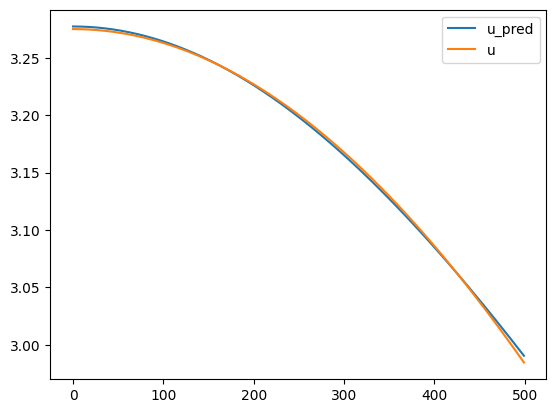

epoch 491 / 500 : loss = 0.1450612097978592
epoch 492 / 500 : loss = 0.1450590193271637
epoch 493 / 500 : loss = 0.14505645632743835
epoch 494 / 500 : loss = 0.14505428075790405


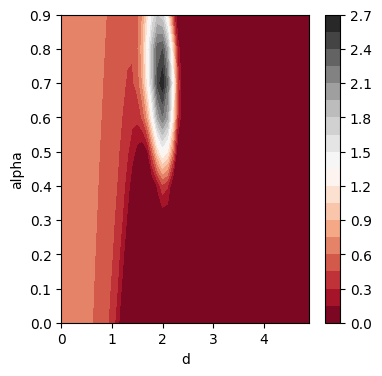

epoch 495 / 500 : loss = 0.14505216479301453


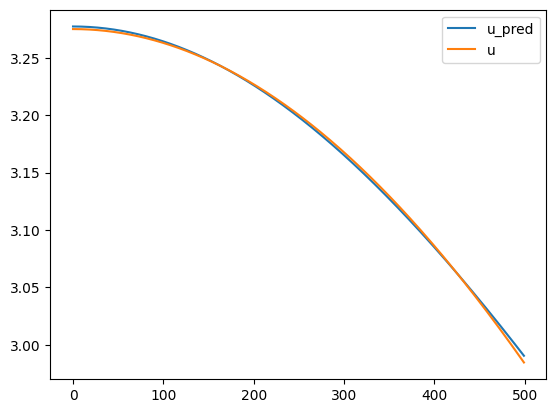

epoch 496 / 500 : loss = 0.14504939317703247
epoch 497 / 500 : loss = 0.14504726231098175
epoch 498 / 500 : loss = 0.14504501223564148
epoch 499 / 500 : loss = 0.1450428068637848


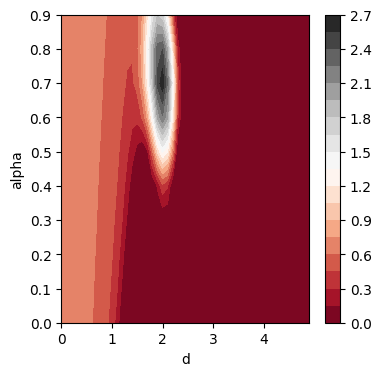

epoch 500 / 500 : loss = 0.14504007995128632


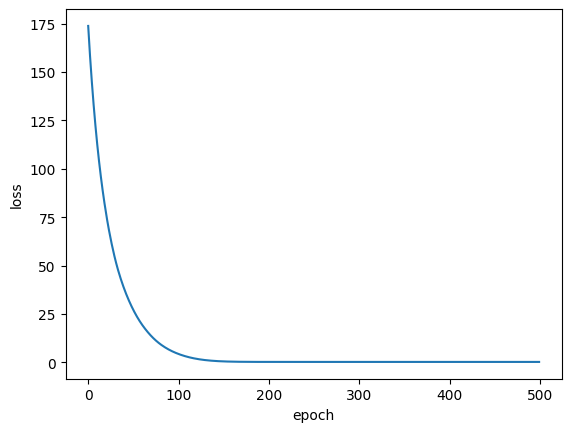

In [26]:
# train the model
P_alpha_d = train(P_alpha_d, u, Z, alpha_vals, d_vals, num_epochs=500, lr=1e-2)

In [27]:
P_alpha_d_cpu = P_alpha_d.cpu().detach().numpy()
# normalize P_alpha_d_cpu
# P_alpha_d_cpu = P_alpha_d_cpu / (P_alpha_d_cpu.sum(axis=(1,2), keepdims=True))
print(f"shape of P_alpha_d_cpu : {P_alpha_d_cpu.shape}")
# save P_alpha_d_cpu
np.save("P_alpha_d_cpu.npy", P_alpha_d_cpu)

shape of P_alpha_d_cpu : (100, 10, 50)


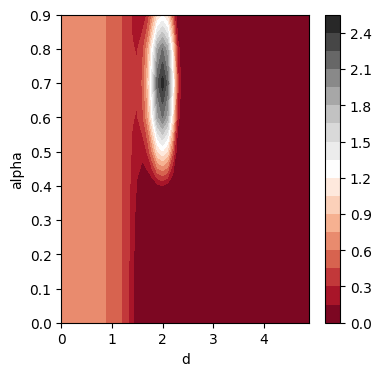

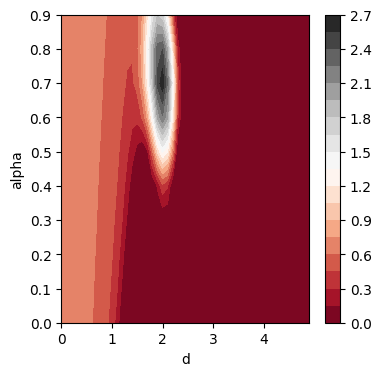

In [28]:
for i in range(0, s_vals.shape[0], 50):
    # copy P_alpha_d to cpu
    contour_plt(P_alpha_d_cpu, i)

In [29]:
# def give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals):
#     """
#     Given P_alpha_d, Z, alpha_vals, d_vals, return u_pred
#     """
#     # initialize u_pred
#     u_pred = np.zeros((s_vals.shape[0], len(r_vals)))

#     # convert P_alpha_d to numpy array
#     P_alpha_d = P_alpha_d.cpu().detach().numpy()
#     Z = Z.cpu().detach().numpy()
#     alpha_vals = alpha_vals.cpu().detach().numpy()
#     d_vals = d_vals.cpu().detach().numpy()

#     for i in range(u_pred.shape[0]):
#         for j in range(u_pred.shape[1]):
#             integrand = np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals, axis=1)
#             u_pred[i, j] = np.trapz(integrand, alpha_vals)

#     # normalize u_pred
#     u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True) + 1e-6)
#     # u_pred = u_pred / (u_pred.sum(axis=1, keepdims=True))

#     # s_vals = np.linspace(0.0, 2*np.pi, 101)
#     s_vals = np.linspace(0.1, 20.1, 101)
#     # s_vals[0] = 1e-10
#     s_vals = s_vals[:-1]

#     # get the range of k values
#     # convert r_vals to numpy array
#     r_vals = r_vals.cpu().detach().numpy()
#     k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
#     k_vals = fft.fftshift(k_vals)
#     # k_vals = 2 * np.pi * k_vals
#     # print(k_vals)
#     print(f"shape of k_vals : {k_vals.shape}")

#     # visualize u_pred
#     plt.figure(figsize=(10, 8))
#     plt.title("u_pred(s, k) for some s values")
#     plt.xlabel("k")
#     plt.ylabel("u_pred(s, k)")
#     plt.grid()
#     for i in range(0, s_vals.shape[0], s_vals.shape[0]//10):
#         if i == 0:
#             continue
#         plt.plot(k_vals, u_pred[i, :], label=f"s = {s_vals[i]:.2f}")

#     plt.legend()
#     plt.show()

In [30]:
# reproduce u_pred
# give_u_pred_np_and_plot(P_alpha_d, Z, alpha_vals, d_vals, r_vals)
